# Imports and Data

In [452]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
unfiltered['mit'] = pc.allcalls('/Users/vsvh/Desktop/DataRelease/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
    
calls = {}
for c in ['uk', 'uk1', 'uk2', 'mit', 'it', 'it1', 'it2']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [262]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()
    
pikachu = {}
for it in ['it1', 'it2']:
    pikachu[it] = {}
    for ego in tmpdff[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
        pikachu['it'] = pikachu.get('it', {})
        pikachu['it'][f'{thekey[it]}{ego}'] = {}
        pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

raichu = {}
for it in ['it1', 'it2']:
    raichu[it] = {}
    for ego in tmplives[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
        raichu['it'] = raichu.get('it', {})
        raichu['it'][f'{thekey[it]}{ego}'] = {}
        raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [457]:
lives = {}
forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    # if (c == 'it1') or (c == 'it2'):
    #     lives[c] = raichu[c]
    #     lives['all'] = lives.get('all', {})
    #     lives['all'].update(lives[c])
    # elif c == 'it':
    #     lives[c] = raichu[c]
    if c in ['uk1', 'uk2', 'it1', 'it2']:
        cdf = calls[c].loc[calls[c]['aclock'] <= 300]
        lf = pc.lives_dictionary(cdf)
        lives[c] = {}
        for ego in lf.keys():
            thekey = f'{forkey[c]}{ego}'
            lives[c][thekey] = lf[ego]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'uk':
        lives[c] = {}
        for u in ['uk1', 'uk2']:
            lives[c].update(lives[u])
    elif c == 'it':
        lives[c] = {}
        for u in ['it1', 'it2']:
            lives[c].update(lives[u])
    else:
        lives[c] = pc.lives_dictionary(calls[c])
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])

In [264]:
# dffcomb = {}
# for c in ['it', 'it1', 'it2']:
#     dffcomb[c] = pikachu[c]

dffcomb['uk'] = {}
dffcomb['it'] = {}
for c in ['uk1', 'uk2', 'it1', 'it2']:
    cdf = calls[c].loc[calls[c]['aclock'] <= 300]
    ddf = pc.get_f(cdf, 'all', 15, 10)
    dffcomb[c] = {}
    forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
    for ego in ddf.keys():
        dffcomb[c][f'{forkey[c]}{ego}'] = {}
        for alter in ddf[ego].keys():
            df1 = ddf[ego][alter]
            df2 = df1.loc[(df1['alpha'] <= 20)]
            dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
            if c in ['uk1', 'uk2']:
                dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
                dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
            else:
                dffcomb['it'][f'{forkey[c]}{ego}'] = dffcomb['it'].get(f'{forkey[c]}{ego}', {})
                dffcomb['it'][f'{forkey[c]}{ego}'][alter] = dffcomb['it'][f'{forkey[c]}{ego}'].get(alter, df2)
            
dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [334]:
limits = [(0, 50), (100, 150), (200, 250)]

In [374]:
t0 = dt.datetime.now()

fig1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = {}
        fig1[c][i]['f'] = pc.get_avgfa(dffcomb[c], lives[c], limits[i][0], limits[i][1])
        fig1[c][i]['fi'] = {}
        for ego in dffcomb[c].keys():
            tmp = {ego: dffcomb[c][ego]}
            fig1[c][i]['fi'][ego] = pc.get_avgfa(tmp, lives[c], limits[i][0], limits[i][1])
        
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.400232


In [342]:
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
[[1, 2], [0.8832658694917743, 0.8832658694917743], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8832658694917743) -- (axis cs: 2, 0.8832658694917743);
[[1, 9], [1.5103179209871753, 1.5103179209871753], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.6350289835055056) -- (axis cs: 7, 1.6350289835055056);
[[1, 15], [2.1930102849634716, 2.1930102849634716], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 2, 2.1903563692547827) -- (axis cs: 14, 2.1903563692547827);
=======================uk2=====================
[[1, 2], [0.6647318258067262, 0.6647318258067262], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
[[1, 9], [1.571091122048576, 1.571091122048576], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
[[1, 15], [2.138590886620464, 2.138590886620464], 999]
\draw[dashed, ekans, ultra thick] 

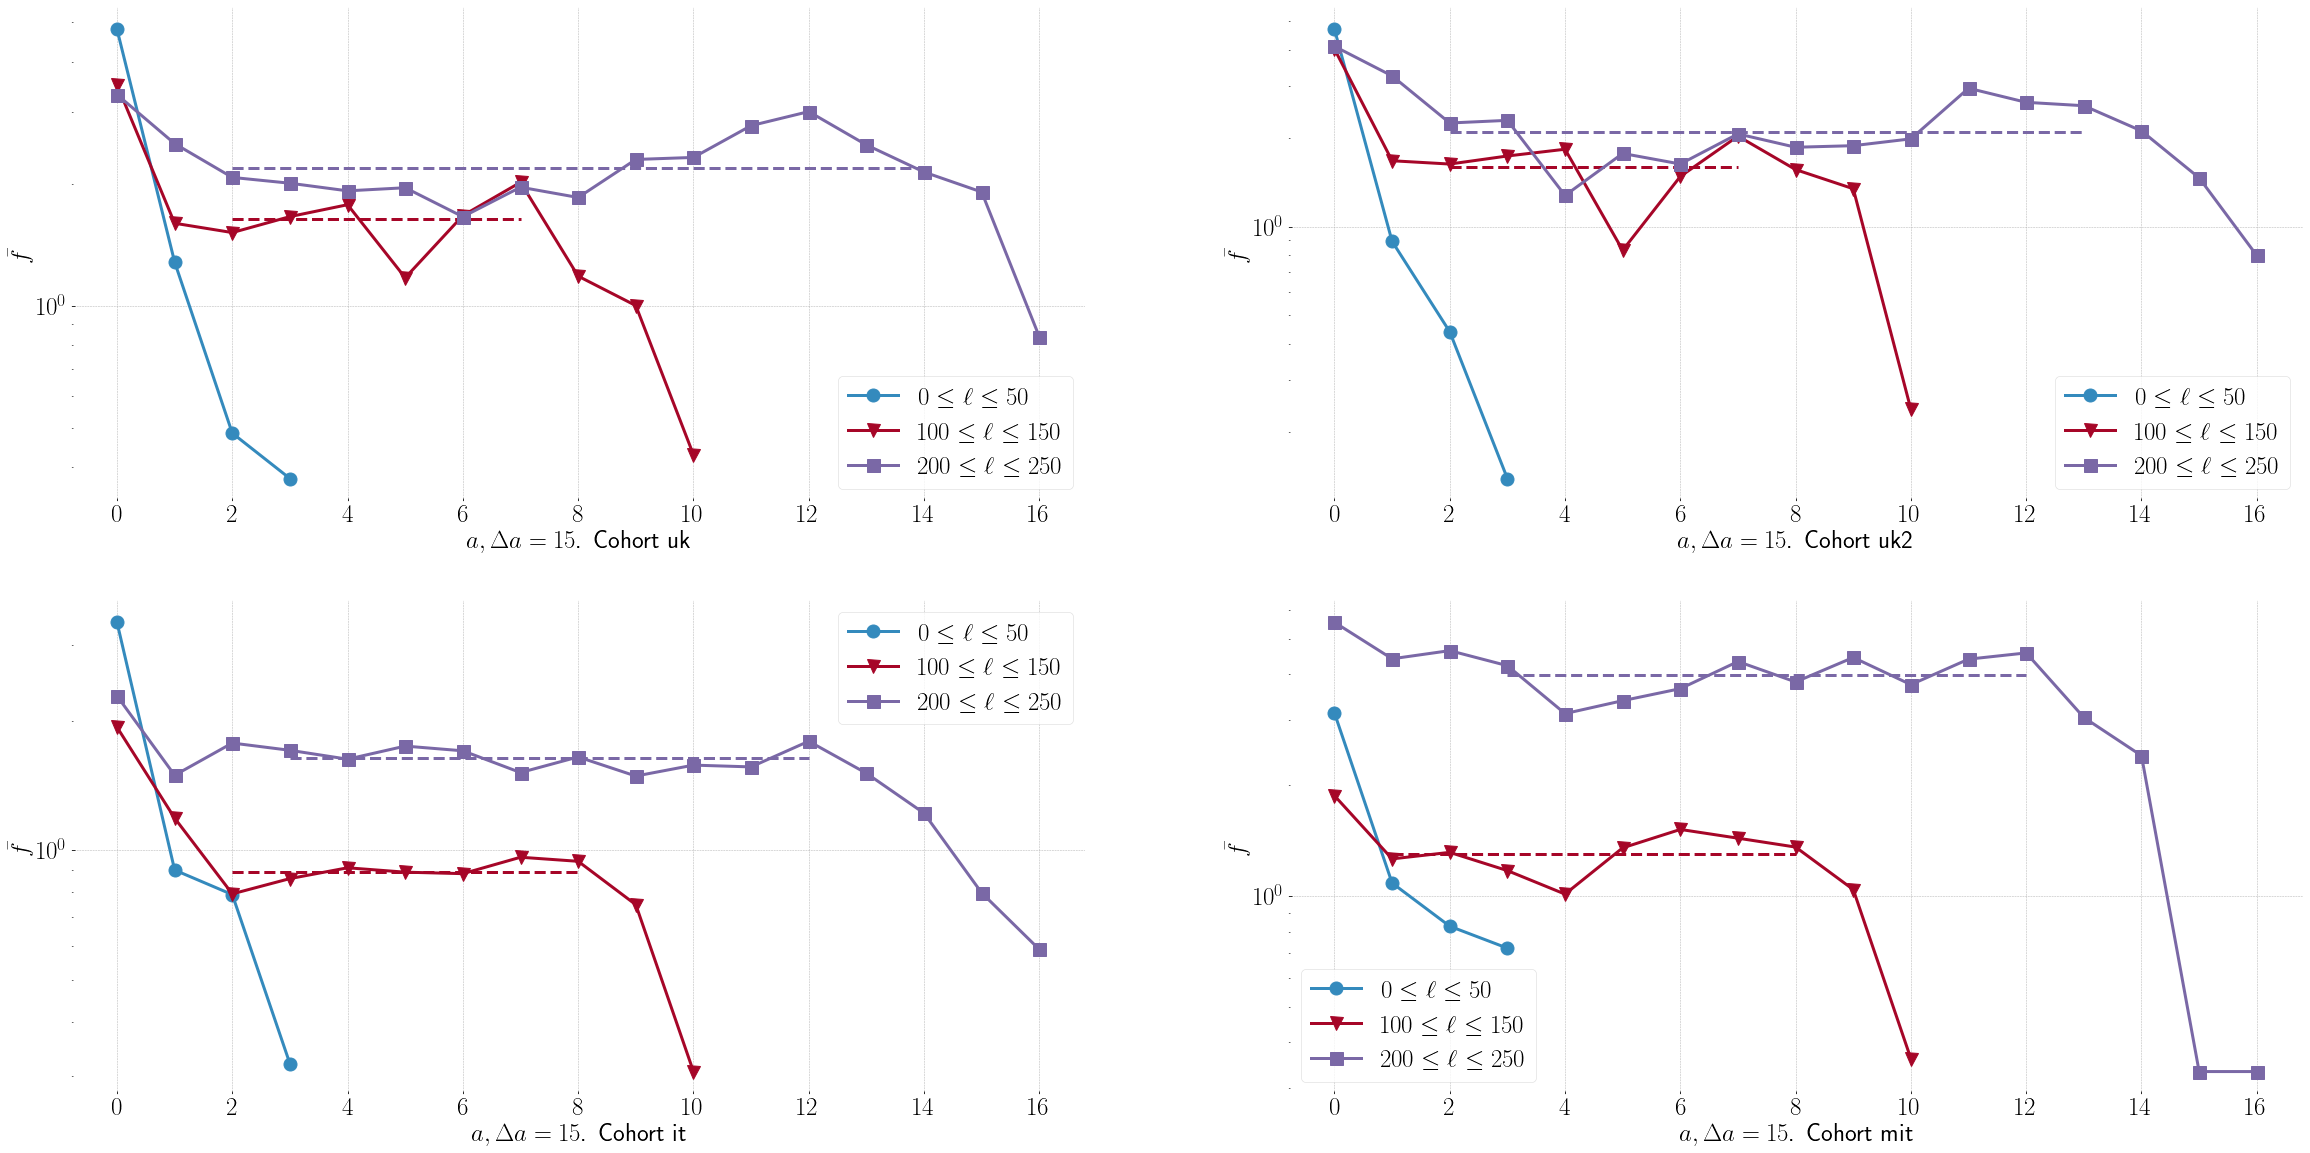

In [337]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [340]:
for c in fig1.keys():
    tmp = pd.DataFrame()
    for l in fig1[c].keys():
        df = fig1[c][l]['f']
        df.columns = [f'l{int(l)}']
        if len(tmp) == 0:
            tmp = tmp.append(df)
        else:
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    # tmp.index.rename('a', inplace=True)
    # tmp.fillna('nan', inplace=True)
    # tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

# Fig 2

In [343]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [344]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

In [345]:
for c in ksp.keys():
    for k in ksp[c].keys():
        lista = ksp[c][k]
        count = 0
        for i in lista:
            if i < 0.05:
                count += 1
        print(c, k, count/len(lista))

uk m 0.0
uk l 0.01818181818181818
uk2 m 0.0
uk2 l 0.038461538461538464
it m 0.0
it l 0.006211180124223602
mit m 0.0
mit l 0.0


In [346]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [273]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [347]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

/Users/vsvh/Documents/research/comm_patterns_git/phonecalls.py:698: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [348]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [349]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [350]:
dashed

{'uk': {0: [[1, 2], [0.8832658694917743, 0.8832658694917743]],
  1: [[2, 7], [1.6350289835055056, 1.6350289835055056]],
  2: [[2, 14], [2.1903563692547827, 2.1903563692547827]]},
 'uk2': {0: [[1, 2], [0.6647318258067262, 0.6647318258067262]],
  1: [[2, 7], [1.5923360902462018, 1.5923360902462018]],
  2: [[2, 13], [2.103012165846757, 2.103012165846757]]},
 'it': {0: [[1, 2], [0.8442913094667548, 0.8442913094667548]],
  1: [[2, 8], [0.891389010039064, 0.891389010039064]],
  2: [[3, 12], [1.6353976371685657, 1.6353976371685657]]},
 'mit': {0: [[1, 2], [0.9557079725829726, 0.9557079725829726]],
  1: [[1, 8], [1.3020376463642513, 1.3020376463642513]],
  2: [[3, 12], [3.9712597791641904, 3.9712597791641904]]}}

# Fig 3 with resampling

In [351]:
dffsurv = {}
dffsurv['all'] = {}
for c in dffcomb.keys():
    if c in ['it1', 'it2', 'uk1', 'uk2', 'mit']:
        dffsurv['all'].update(dffcomb[c])
    if c in ['uk', 'uk2', 'it', 'mit']:
        dffsurv[c] = dffcomb[c]

In [352]:
fig3 = {}
for c in dffsurv.keys():
    fig3[c] = pc.get_survival(dffsurv[c], alphafixed=(2,3), externalell=lives[c], lambdamax=25)

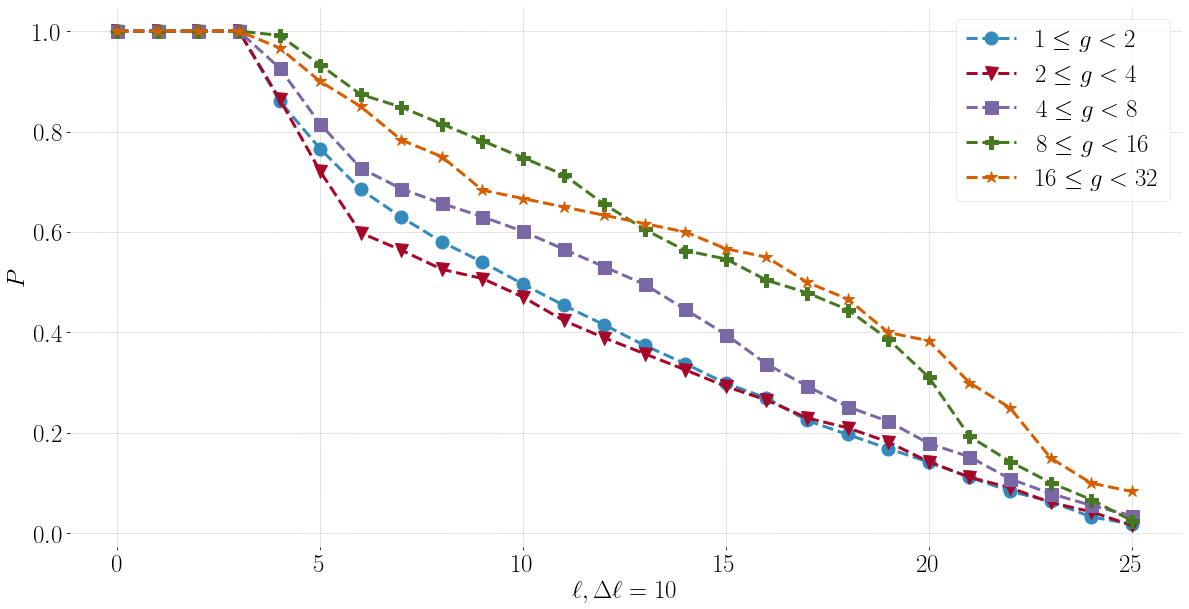

In [353]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(5):
    plt.plot(fig3['all'][i].index, fig3['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

In [354]:
tmp = pd.DataFrame({'lc': list(fig3['all'][0].index)})
for s in range(6):
    df = fig3['all'][s]
    tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

## Using an alternative function

In [541]:
callsurv = {}
callsurv['all'] = pd.DataFrame()
callsurv['uk'] = pd.DataFrame()
callsurv['it'] = pd.DataFrame()
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
    df = calls[c].loc[calls[c]['aclock'] <= 300]
    if c != 'mit':
        if c in ['uk1', 'it1']:
            df['ego'] = df['ego'].map(lambda i: 'a'+str(i))
        elif c in ['uk2', 'it2']:
            df['ego'] = df['ego'].map(lambda i: 'b'+str(i))
        callsurv[c] = df
        if c in ['uk1', 'uk2']:
            callsurv['uk'] = callsurv['uk'].append(df)
        elif c in ['it1', 'it2']:
            callsurv['it'] = callsurv['it'].append(df)
        callsurv['all'] = callsurv['all'].append(df)
    else:
        callsurv[c] = df
        callsurv['all'] = callsurv['all'].append(df)

/var/folders/c1/dbn37n492mz65yl47z1jb0sc0000gn/T/ipykernel_2151/739167691.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ego'] = df['ego'].map(lambda i: 'a'+str(i))
/var/folders/c1/dbn37n492mz65yl47z1jb0sc0000gn/T/ipykernel_2151/739167691.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ego'] = df['ego'].map(lambda i: 'b'+str(i))


In [542]:
len(callsurv['all']) == len(callsurv['uk1']) + len(callsurv['uk2']) + len(callsurv['it1']) + len(callsurv['it2']) + len(callsurv['mit'])

True

In [543]:
len(callsurv['uk']) == len(callsurv['uk1']) + len(callsurv['uk2'])

True

In [544]:
len(callsurv['it']) == len(callsurv['it1']) + len(callsurv['it2'])

True

In [545]:
fig3b = {}
for c in ['all', 'uk', 'uk2', 'it', 'mit']:
    fig3b[c] = pc.get_survival2(callsurv[c], 30, 60)

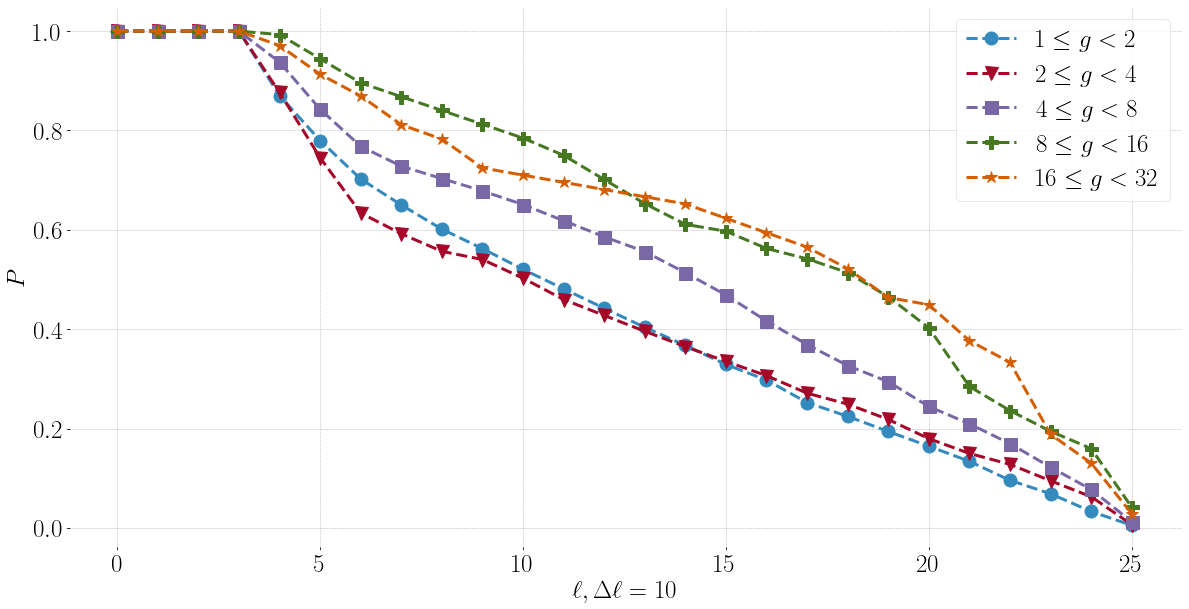

In [547]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(5):
    plt.plot(fig3b['all'][i].index, fig3b['all'][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

# Fig 4 with resampling

In [355]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffUM, lambdamax = 25, alphafixed=(2,3), externalell=lives['all'])

In [356]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [358]:
points_it = pc.get_survival(dffsurv['it'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_it.keys():
    if s <= 2**5 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# SI with resampling

## Using different values for $\Delta t_w$

In [359]:
unfiltered.keys()

dict_keys(['mit', 'uk1', 'uk2', 'uk', 'all', 'it', 'it1', 'it2'])

In [360]:
t0 = dt.datetime.now()

# with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
#     tmpdff = pickle.load(handle)
#     handle.close()
    
# with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
#     tmplives = pickle.load(handle)
#     handle.close()
    
# venonat = {}
# for it in ['it1', 'it2']:
#     venonat[it] = {}
#     for tw in [10, 30, 60, 90]:
#         venonat[it][tw] = {}
#         for ego in tmpdff[it][tw].keys():
#             thekey = {"it1": "a", "it2": "b"}
#             venonat[it][tw][f'{thekey[it]}{ego}'] = tmpdff[it][tw][ego]
#             venonat['it'] = venonat.get('it', {})
#             venonat['it'][tw] = venonat['it'].get(tw, {})
#             venonat['it'][tw][f'{thekey[it]}{ego}'] = {}
#             venonat['it'][tw][f'{thekey[it]}{ego}'].update(tmpdff[it][tw][ego])

# venomoth = {}
# for it in ['it1', 'it2']:
#     venomoth[it] = {}
#     for tw in [10, 30, 60, 90]:
#         venomoth[it][tw] = {}
#         for ego in tmplives[it][tw].keys():
#             thekey = {"it1": "a", "it2": "b"}
#             venomoth[it][tw][f'{thekey[it]}{ego}'] = tmplives[it][tw][ego]
#             venomoth['it'] = venomoth.get('it', {})
#             venomoth['it'][tw] = venomoth['it'].get(tw, {})
#             venomoth['it'][tw][f'{thekey[it]}{ego}'] = {}
#             venomoth['it'][tw][f'{thekey[it]}{ego}'].update(tmplives[it][tw][ego])
        
livestw = {}
forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    livestw[c] = {}
    for tw in [10, 30, 50, 60, 90]:
        # if (c == 'it1') or (c == 'it2'):
        #     livestw[c][tw] = venomoth[c][tw]
        #     livestw['all'] = livestw.get('all', {})
        #     livestw['all'][tw] = livestw['all'].get(tw, {})
        #     livestw['all'][tw].update(livestw[c][tw])
        # elif c == 'it':
        #     livestw[c][tw] = venomoth[c][tw]
        if c in ['uk1', 'uk2', 'it1', 'it2']:
            callsdf = pc.apply_filters(unfiltered[c], tw)
            cdf = callsdf[callsdf['aclock'] <= 300]
            lf = pc.lives_dictionary(cdf)
            livestw[c][tw] = {}
            for ego in lf.keys():
                thekey = f'{forkey[c]}{ego}'
                livestw[c][tw][thekey] = lf[ego]
            livestw['all'] = livestw.get('all', {})
            livestw['all'][tw] = livestw['all'].get(tw, {})
            livestw['all'][tw].update(livestw[c][tw])
        elif c == 'uk':
            livestw[c][tw] = {}
            for u in ['uk1', 'uk2']:
                livestw[c][tw].update(livestw[u][tw])
        elif c == 'it':
            livestw[c][tw] = {}
            for u in ['it1', 'it2']:
                livestw[c][tw].update(livestw[u][tw])
        else:
            callsdf = pc.apply_filters(unfiltered[c], tw)
            cdf = callsdf.loc[callsdf['aclock'] <= 300]
            livestw[c][tw] = pc.lives_dictionary(cdf)
            livestw['all'] = livestw.get('all', {})
            livestw['all'][tw] = livestw['all'].get(tw, {})
            livestw['all'][tw].update(livestw[c][tw])
        
dfftw = {}
# for c in ['it', 'it1', 'it2']:
#     dfftw[c] = {}
#     for tw in [10, 30, 60, 90]:
#         dfftw[c][tw] = venonat[c][tw]

dfftw['uk'] = {}
dfftw['it'] = {}
for c in ['uk1', 'uk2', 'it1', 'it2']:
    dfftw[c] = {}
    for tw in [10, 30, 50, 60, 90]:
        if c in ['uk1', 'uk2']:
            dfftw['uk'][tw] = {}
        else:
            dfftw['it'][tw] = {}
        callsdf = pc.apply_filters(unfiltered[c], tw)
        cdf = callsdf.loc[callsdf['aclock'] <= 300]
        ddf = pc.get_f(cdf, 'all', 15, 10)
        dfftw[c][tw] = {}
        forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
        for ego in ddf.keys():
            dfftw[c][tw][f'{forkey[c]}{ego}'] = {}
            for alter in ddf[ego].keys():
                df1 = ddf[ego][alter]
                # df2 = df1.loc[(df1['alpha'] <= 20)]
                dfftw[c][tw][f'{forkey[c]}{ego}'][alter] = df1
                if c in ['uk1', 'uk2']:
                    dfftw['uk'][tw][f'{forkey[c]}{ego}'] = dfftw['uk'][tw].get(f'{forkey[c]}{ego}', {})
                    dfftw['uk'][tw][f'{forkey[c]}{ego}'][alter] = dfftw['uk'][tw][f'{forkey[c]}{ego}'].get(alter, df1)
                else:
                    dfftw['it'][tw][f'{forkey[c]}{ego}'] = dfftw['it'][tw].get(f'{forkey[c]}{ego}', {})
                    dfftw['it'][tw][f'{forkey[c]}{ego}'][alter] = dfftw['it'][tw][f'{forkey[c]}{ego}'].get(alter, df1)
            
dfftw['mit'] = {}
for tw in [10, 30, 50, 60, 90]:
    callsdf = pc.apply_filters(unfiltered['mit'], tw)
    cdf = callsdf.loc[callsdf['aclock'] <= 300]
    dfftw['mit'][tw] = pc.get_f(cdf, 'all', 15, 10)

print(f'Took {dt.datetime.now() - t0}')

Took 0:00:33.034557


In [361]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S1[c] = {}
    for Dt in dfftw['uk'].keys():
        S1[c][Dt] = {}
        dff = dfftw[c][Dt]
        for lamb in range(3):
            S1[c][Dt][lamb] = {'f': pc.get_avgfa(dff, livestw[c][Dt], limits[lamb][0], limits[lamb][1])}
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.972330


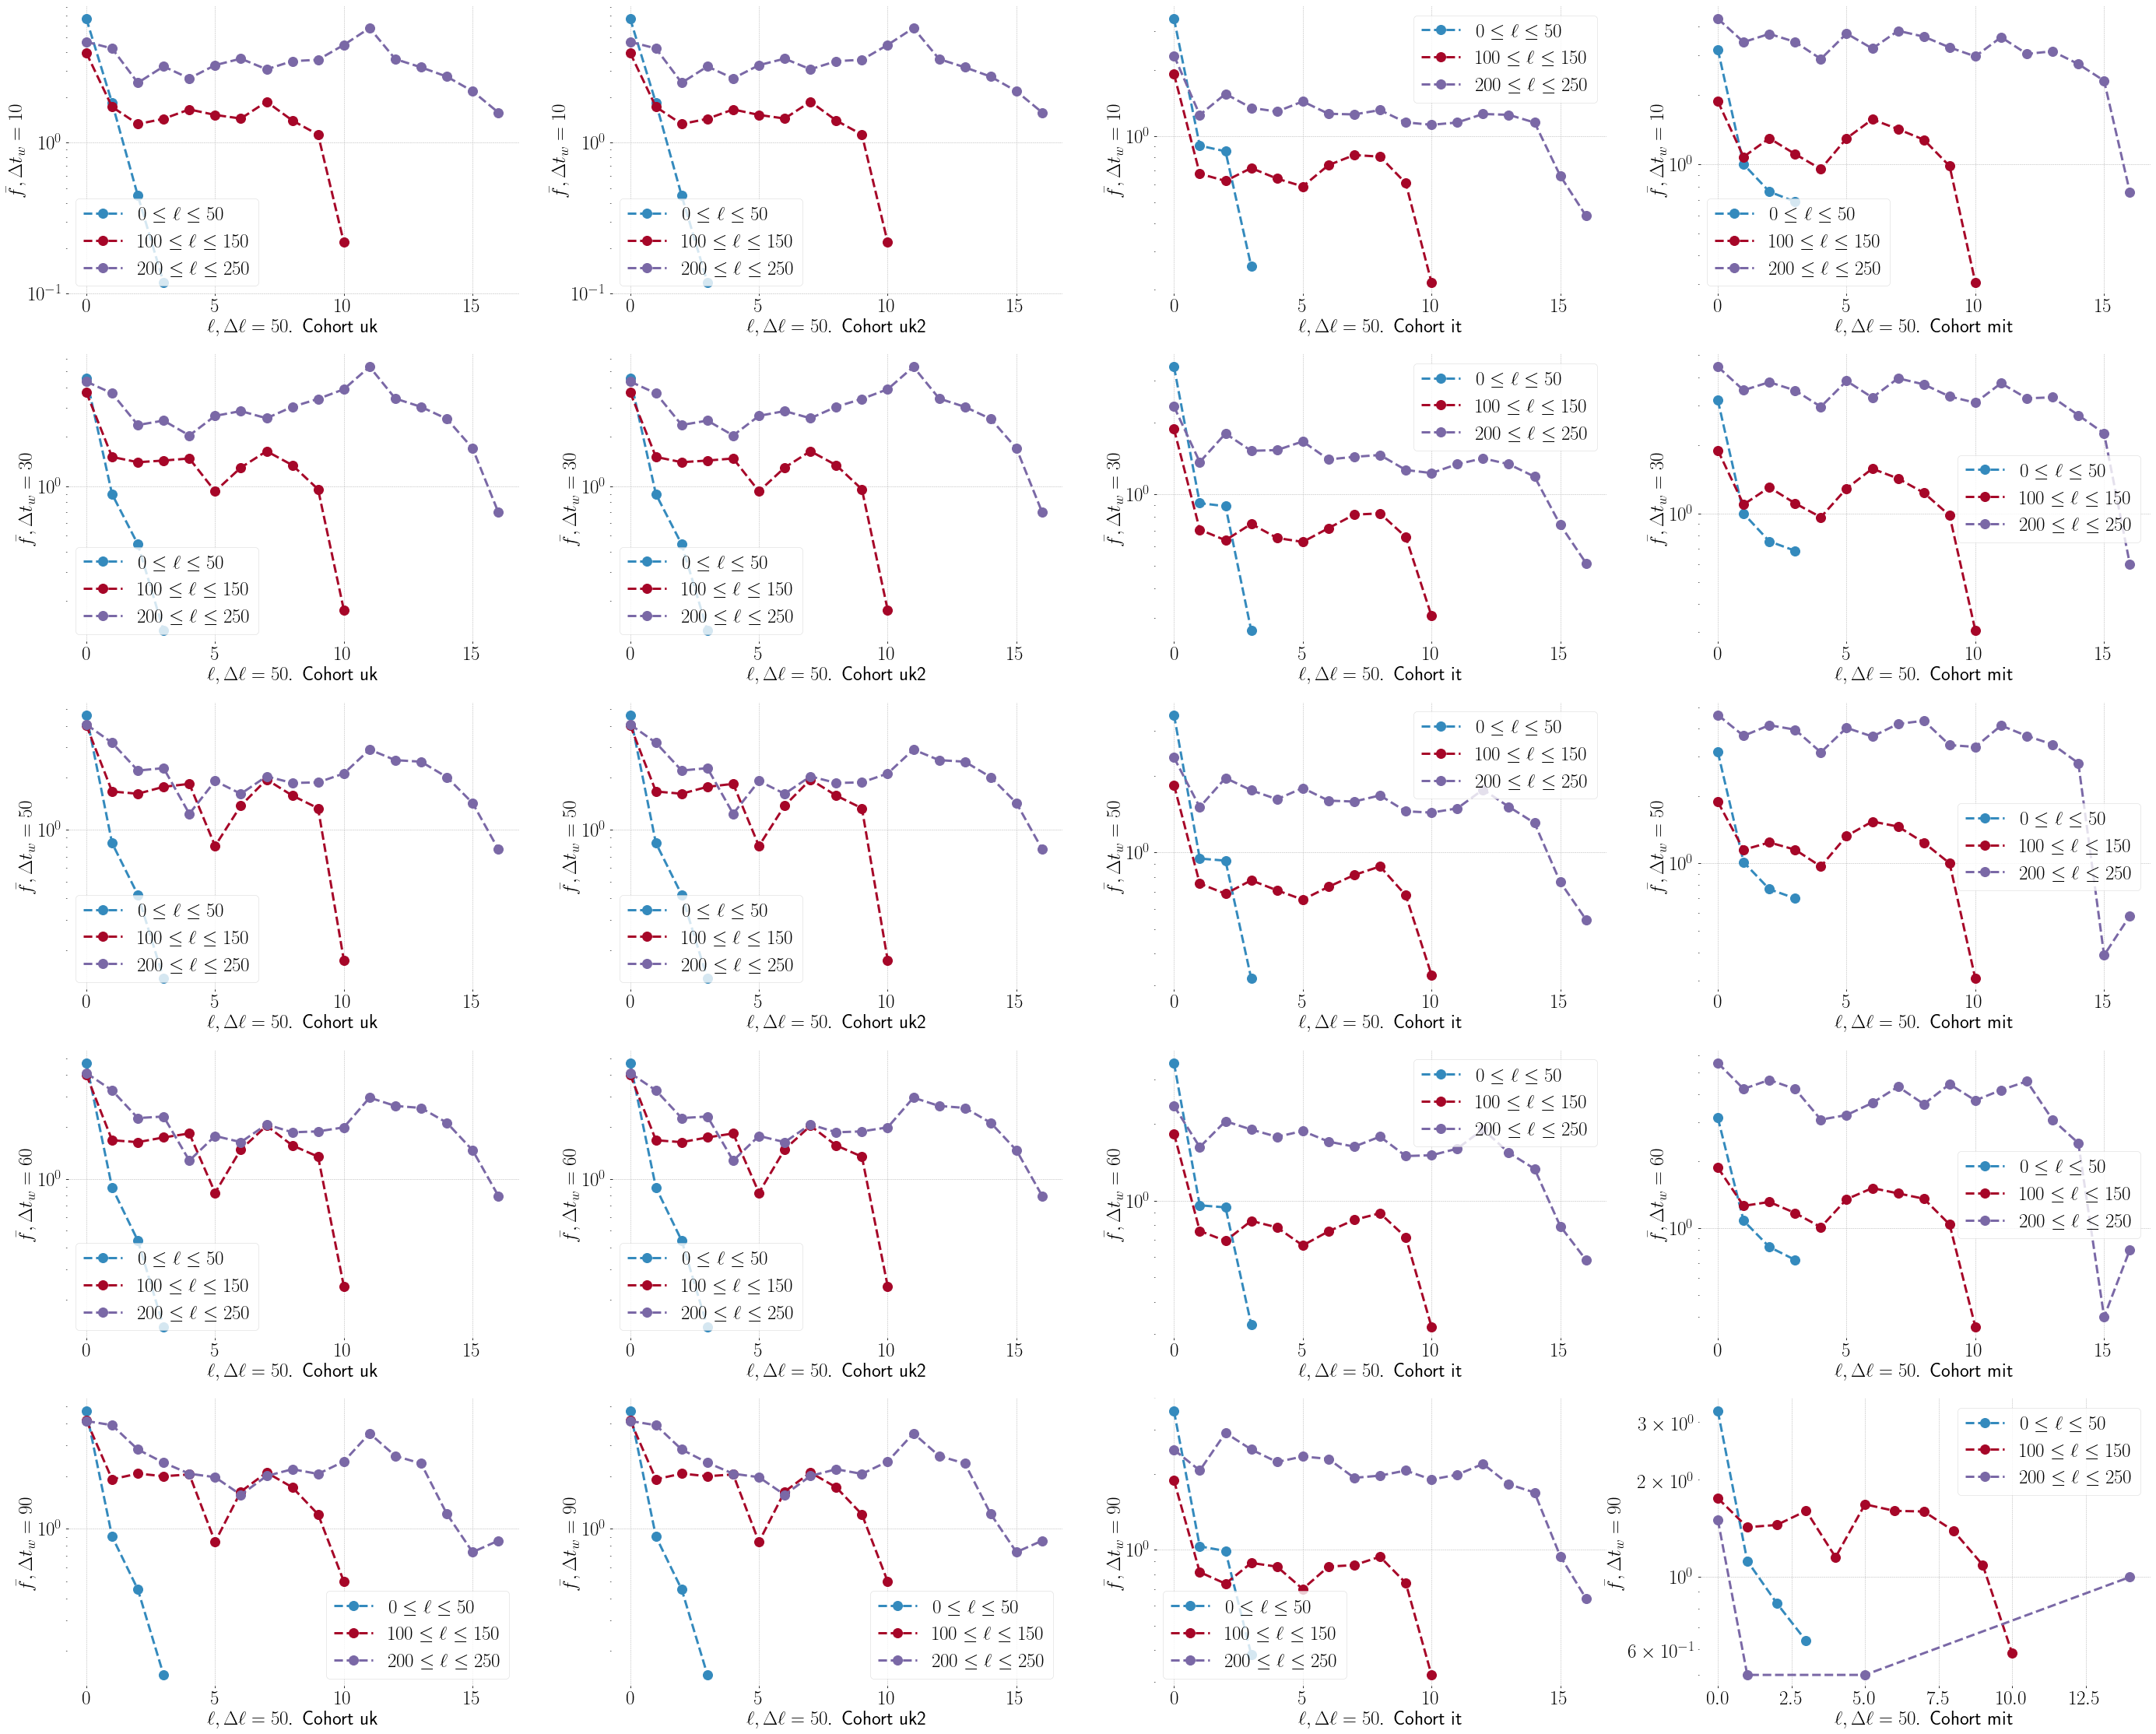

In [362]:
plt.figure(figsize=(12*4, 8*6))
p = 1
for Dt in S1['uk'].keys():
    for c in S1.keys():
        plt.subplot(6, 4, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[lamb][0]}\leq \ell \leq {limits[lamb][1]}$')
        plt.legend()
        p += 1

In [363]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

## Different values for $\Delta \ell$

In [364]:
limits

[(0, 50), (100, 150), (200, 250)]

In [365]:
lims = {}
for i in range(3):
    lims[i] = [limits[i]] + [(limits[i][0], limits[i][0] + Dl) for Dl in [10, 30, 70, 90]]
        
lims

{0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
 1: [(100, 150), (100, 110), (100, 130), (100, 170), (100, 190)],
 2: [(200, 250), (200, 210), (200, 230), (200, 270), (200, 290)]}

In [366]:
S2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            S2[c][i][j] = {'f': pc.get_avgfa(dfftw[c][60], livestw[c][60], lims[i][j][0], lims[i][j][1])}

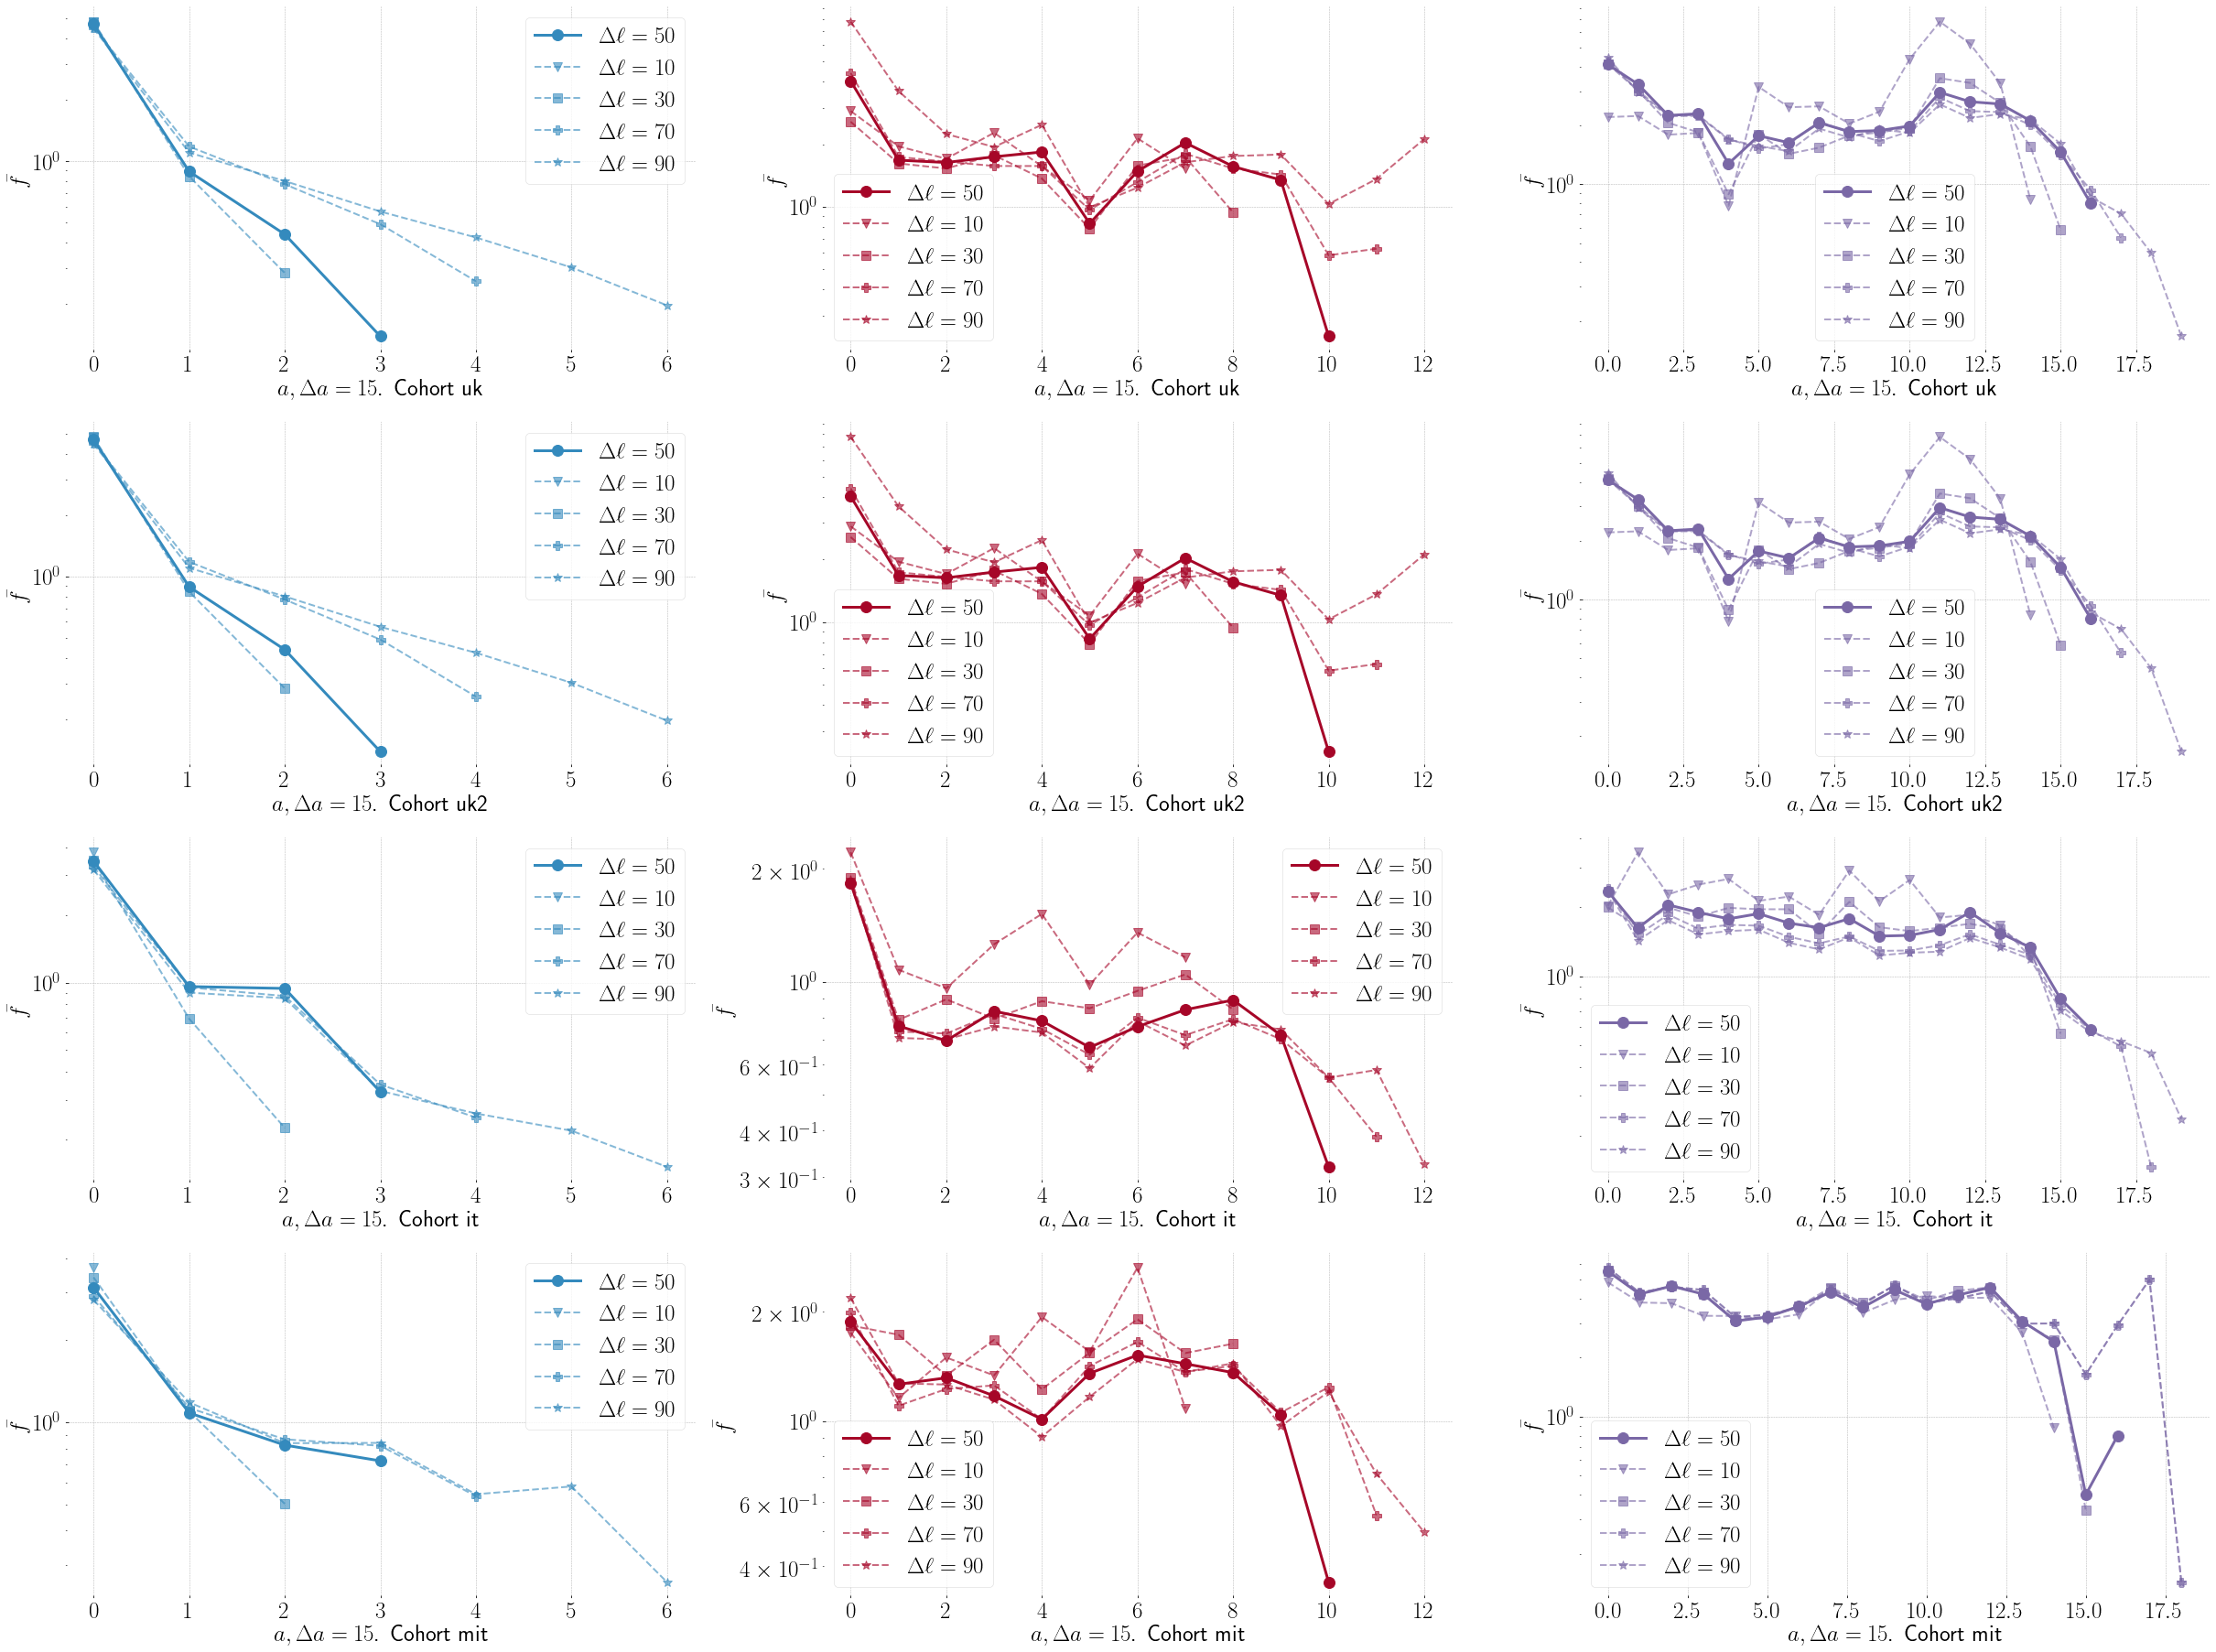

In [367]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(4, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [368]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1: variations of $\Delta a$

In [369]:
dffDa = {}
dffDa['uk'] = {}
dffDa['it'] = {}
forkey = {'uk1': 'a', 'uk2': 'b', 'it1': 'a', 'it2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2']:
    dffDa[c] = {}
    cdf = calls[c].loc[calls[c]['aclock'] <= 300]
    for Da in [5, 10, 15, 30, 45]:
        ddf = pc.get_f(cdf, 'all', Da, 10)
        dffDa[c][Da] = {}
        if c in ['uk1', 'uk2']:
            dffDa['uk'][Da] = {}
        else:
            dffDa['it'][Da] = {}
        for ego in ddf.keys():
            dffDa[c][Da][f'{forkey[c]}{ego}'] = {}
            for alter in ddf[ego].keys():
                df1 = ddf[ego][alter]
                # df2 = df1.loc[(df1['alpha'] <= 300 // Da)]
                dffDa[c][Da][f'{forkey[c]}{ego}'][alter] = df1
                if c in ['uk1', 'uk2']:
                    dffDa['uk'][Da][f'{forkey[c]}{ego}'] = dffDa['uk'][Da].get(f'{forkey[c]}{ego}', {})
                    dffDa['uk'][Da][f'{forkey[c]}{ego}'][alter] = dffDa['uk'][Da][f'{forkey[c]}{ego}'].get(alter, df1)
                else:
                    dffDa['it'][Da][f'{forkey[c]}{ego}'] = dffDa['it'][Da].get(f'{forkey[c]}{ego}', {})
                    dffDa['it'][Da][f'{forkey[c]}{ego}'][alter] = dffDa['it'][Da][f'{forkey[c]}{ego}'].get(alter, df1)
            
dffDa['mit'] = {}
cdf = calls['mit'].loc[calls['mit']['aclock'] <= 300]
for Da in [5, 10, 15, 30, 45]:
    dffDa['mit'][Da] = pc.get_f(cdf, 'all', Da, 10)

In [370]:
Deltaa = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            Deltaa[c][Da][i] = pc.get_avgfa(dffDa[c][Da], lives[c], limits[i][0], limits[i][1])

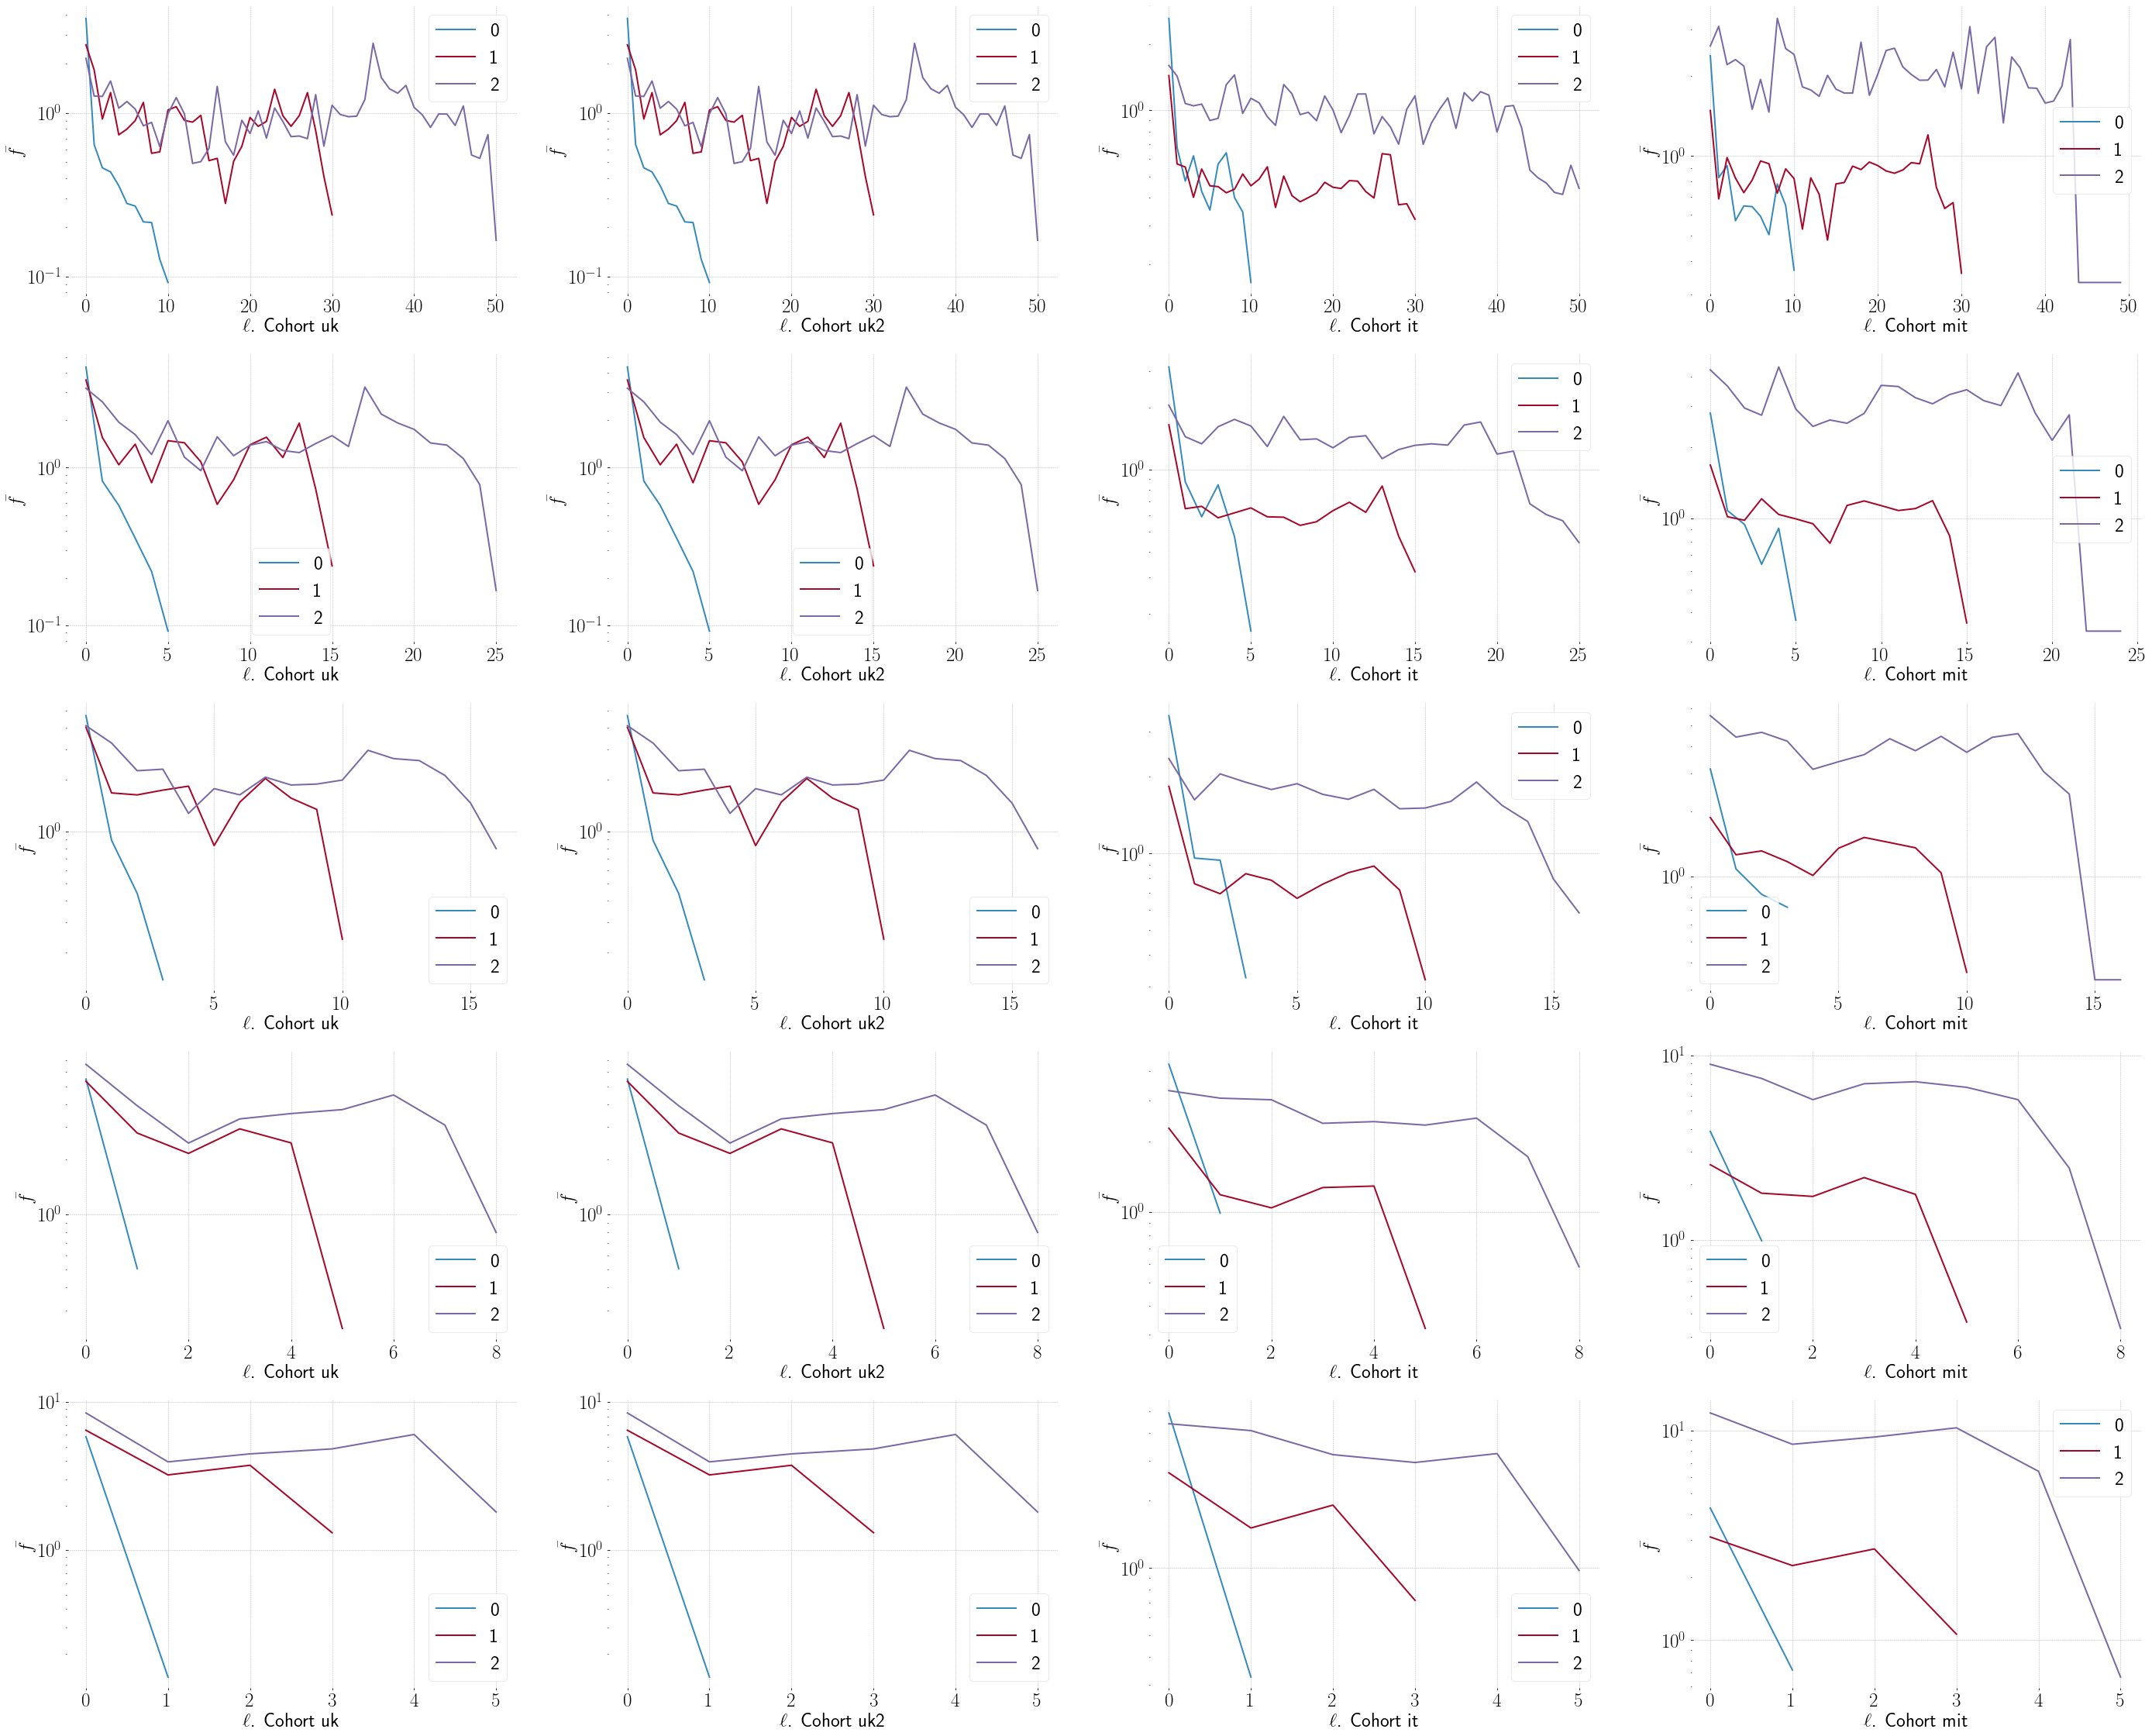

In [371]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(fr'$\ell$. Cohort {c}')
        plt.ylabel(r'$\bar{f}$')
        plt.semilogy()
        for i in range(3):
            plt.plot(Deltaa[c][Da][i].index, Deltaa[c][Da][i]['f'], label=f'{i}')
        plt.legend()
        p += 1

In [372]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [373]:
useegos = []
for e in fig1['mit'][2]['fi'].keys():
    if len(fig1['mit'][2]['fi'][e].index) >= 10:
        useegos.append(e)

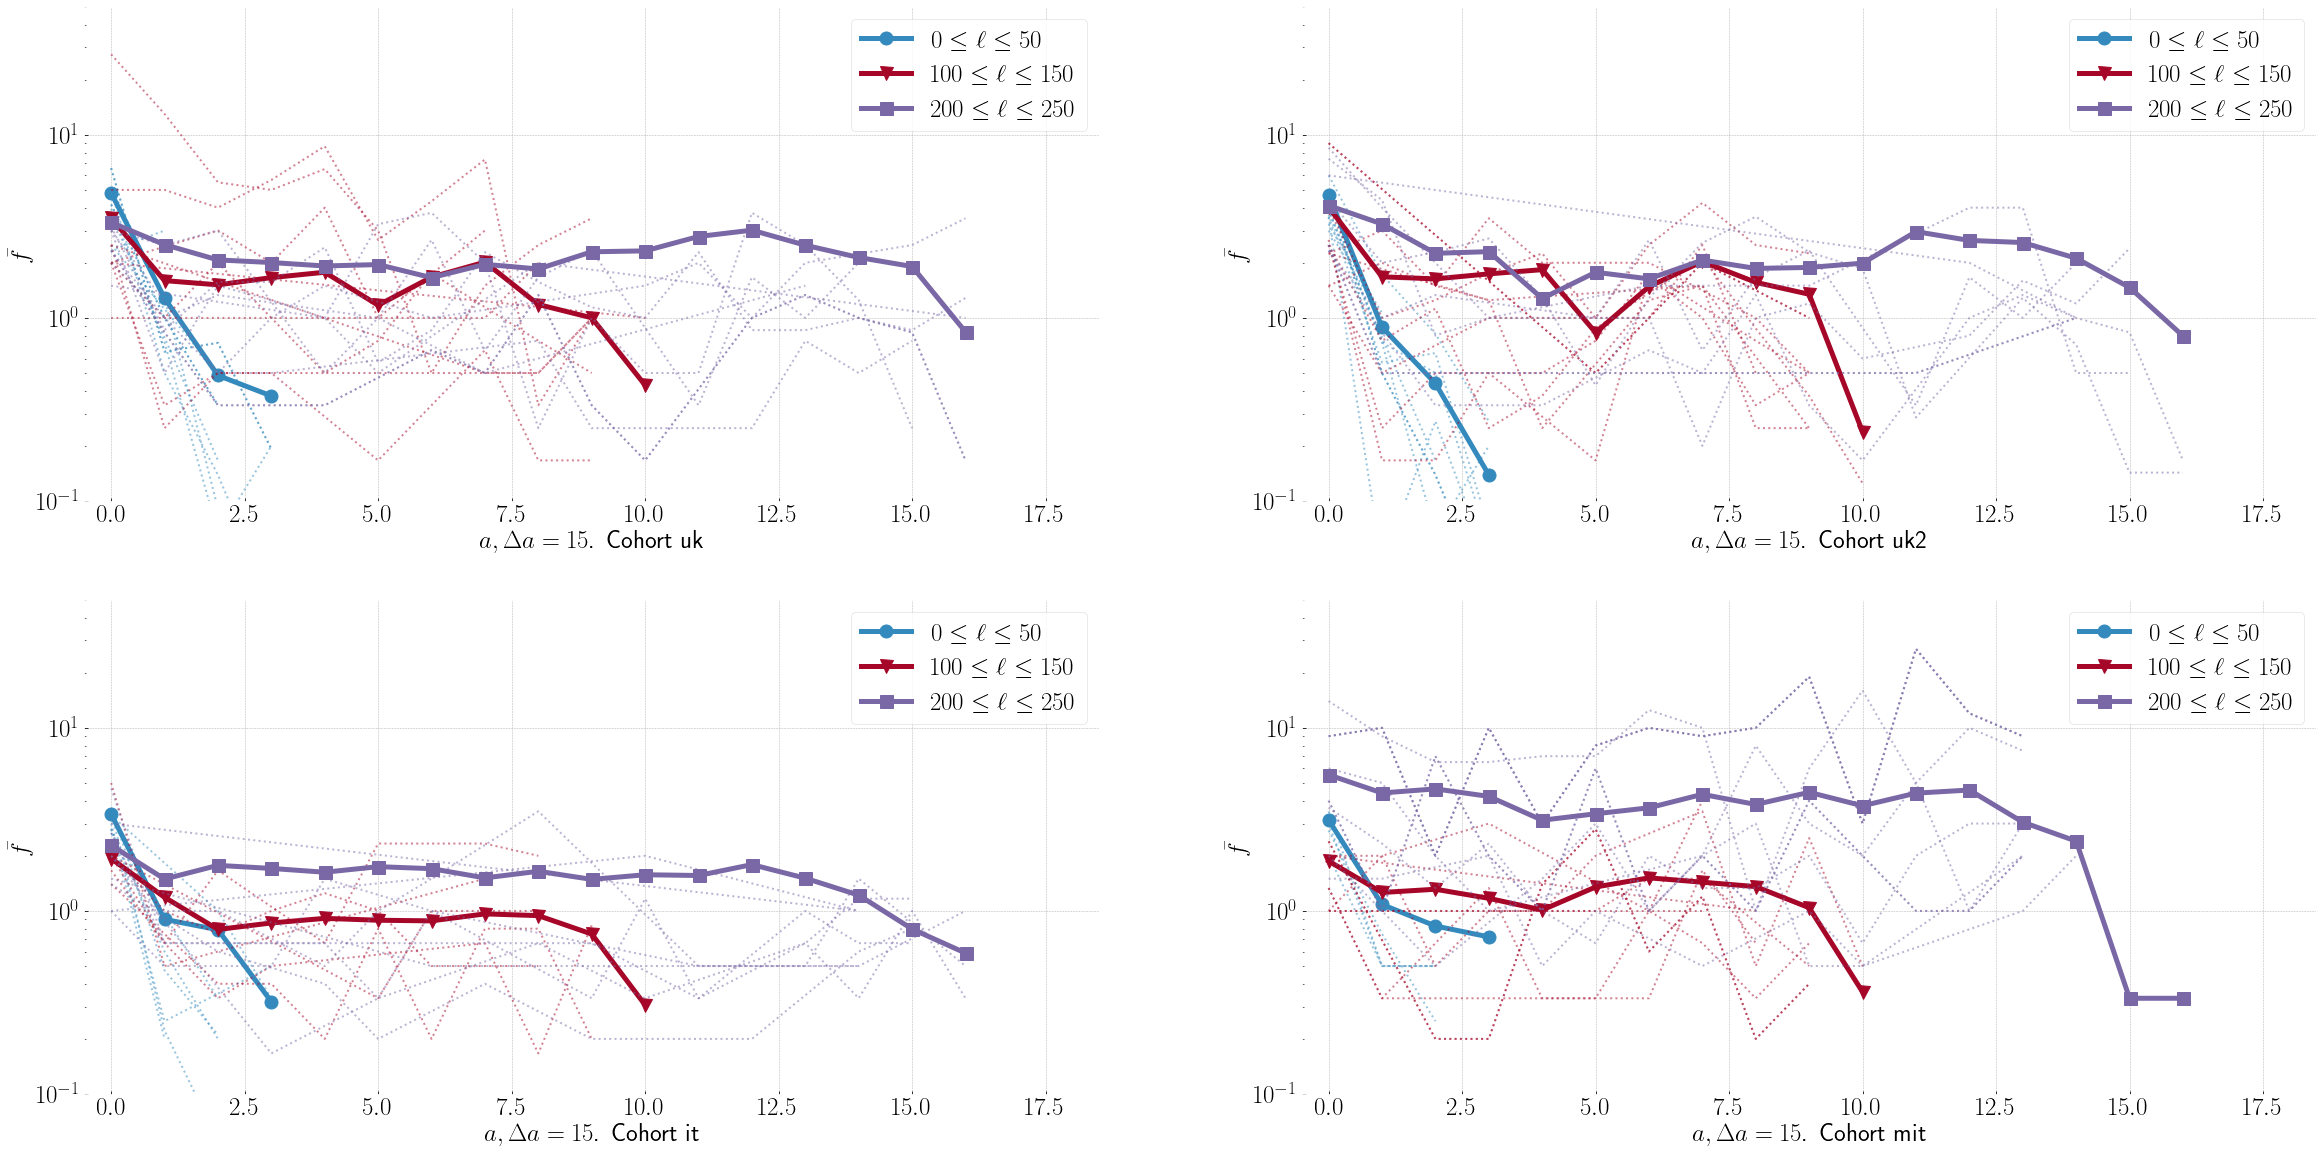

In [375]:
np.random.seed(9)
tmp = pd.DataFrame(index=range(18))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 18.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        if c != 'mit':
            egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        else:
            egos = np.random.choice(useegos, size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [376]:
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

## $b(\ell)$ by cohort

Only when it converges. I may try to  bin the values of $b$ to make it smoother. Also, I will calculate the same measurement considering a combined cohort.

In [377]:
dffcomb['all'] = {}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
    dffcomb['all'].update(dffcomb[c])

In [378]:
t0 = dt.datetime.now()
b = {}
b2 = {}
converge = {}
converge2 = {}
nalt = {}
nego = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit', 'all']:
    b[c] = {}
    b2[c] = {}
    converge[c] = {}
    converge2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(251):
        curve = pc.get_avgfa(dffcomb[c], lives[c], ell, ell + 50, countalt=True)
        if len(curve[0]) > 2:
            points = pc.get_b_slopes(curve[0], FlagConverge=True)
            points2 = pc.get_b_mk(curve[0], FlagConverge=True)
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            converge[c][ell] = points[2]
            converge2[c][ell] = points2[2]
            nalt[c][ell] = curve[1]
            nego[c][ell] = curve[2]
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmpb2 = pd.DataFrame.from_dict(b2[c], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
    tmpc2 = pd.DataFrame.from_dict(converge2[c], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmpb2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmpc2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
    b[c]['mas'] = b[c]['slopes'].rolling(window=50).mean()
    b[c]['mam'] = b[c]['mk'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:23.048941


In [381]:
for c in b.keys():
    print(c, b[c]['convs'].mean())

uk 0.6095617529880478
uk1 0.7888446215139442
uk2 0.5258964143426295
it 0.7529880478087649
it1 0.8007968127490039
it2 0.8087649402390438
mit 0.7808764940239044
all 0.7450199203187251


In [382]:
nea = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit']:
    tmp = dffcomb[c]
    n = 0
    for ego in tmp.keys():
        for alter in tmp[ego].keys():
            n += 1
    nea[c] = n
    
nea

{'uk': 1944,
 'uk1': 1000,
 'uk2': 944,
 'it': 4371,
 'it1': 1400,
 'it2': 2971,
 'mit': 858}

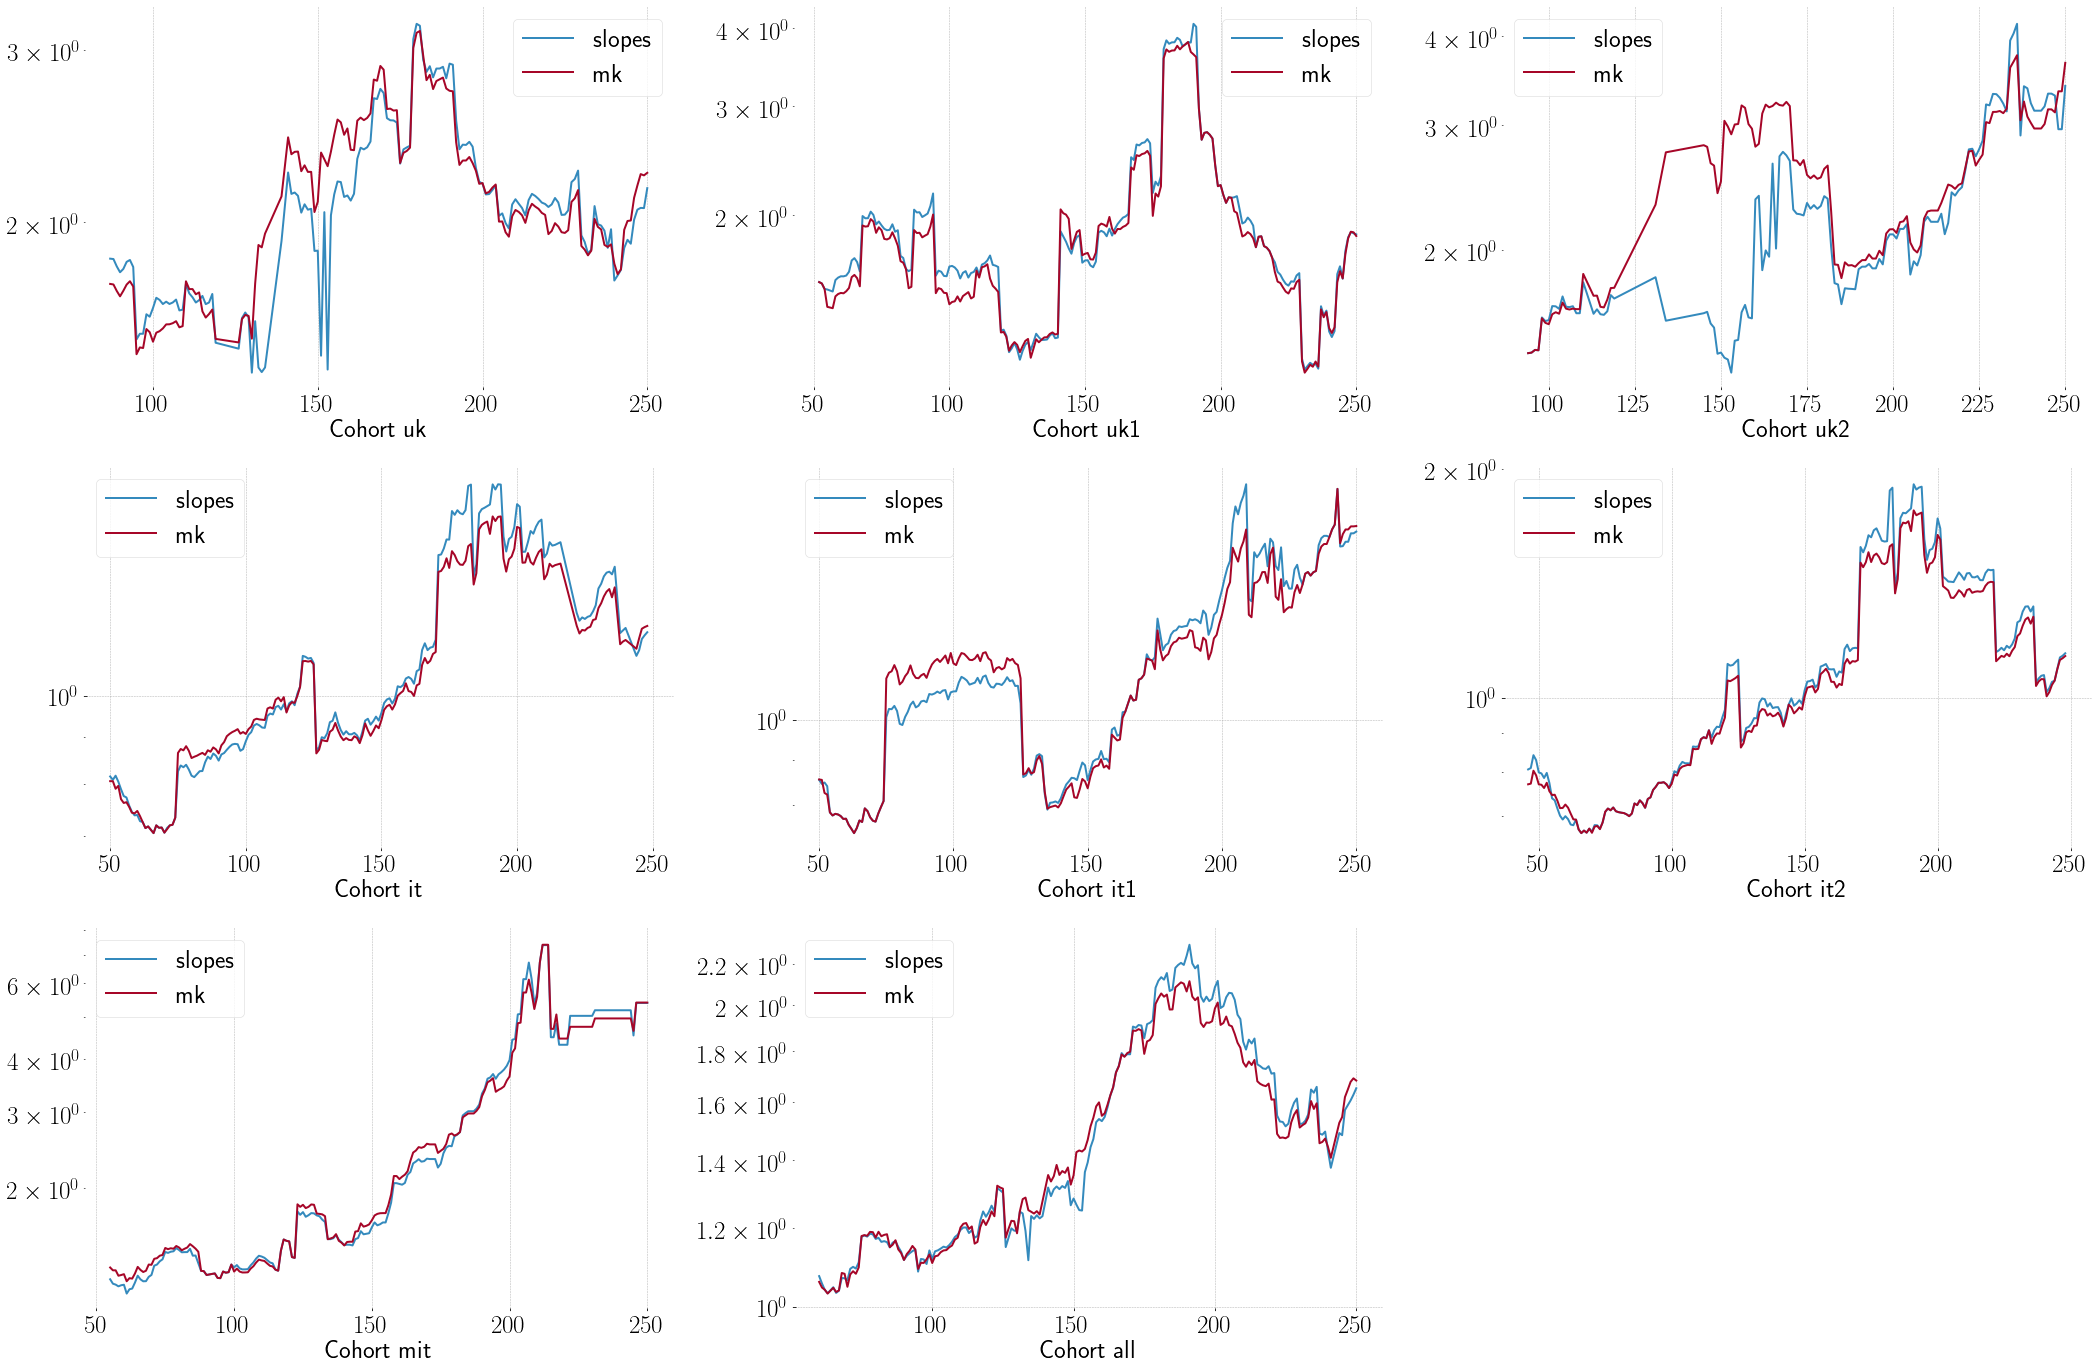

In [383]:
plt.figure(figsize=(12*3, 8*3))
p = 1
for c in b.keys():
    plt.subplot(3,3,p)
    df = b[c].loc[b[c]['convs'] == True]
    plt.semilogy()
    plt.xlabel(f'Cohort {c}')
    plt.plot(df.index, df['slopes'], label="slopes")
    plt.plot(df.index, df['mk'], label='mk')
    plt.legend()
    p += 1

In [384]:
binsize = 50
bbins = {}
for c in b.keys():
    df = b[c].loc[b[c]['convs'] == True]
    df2 = df[['slopes', 'mk']].copy()
    df2['lambda'] = df.index.map(lambda x: x // binsize)
    bbins[c] = df2.groupby('lambda').mean()
    bbins[c]['x'] = bbins[c].index.map(lambda x: (x * binsize) + (binsize // 2))

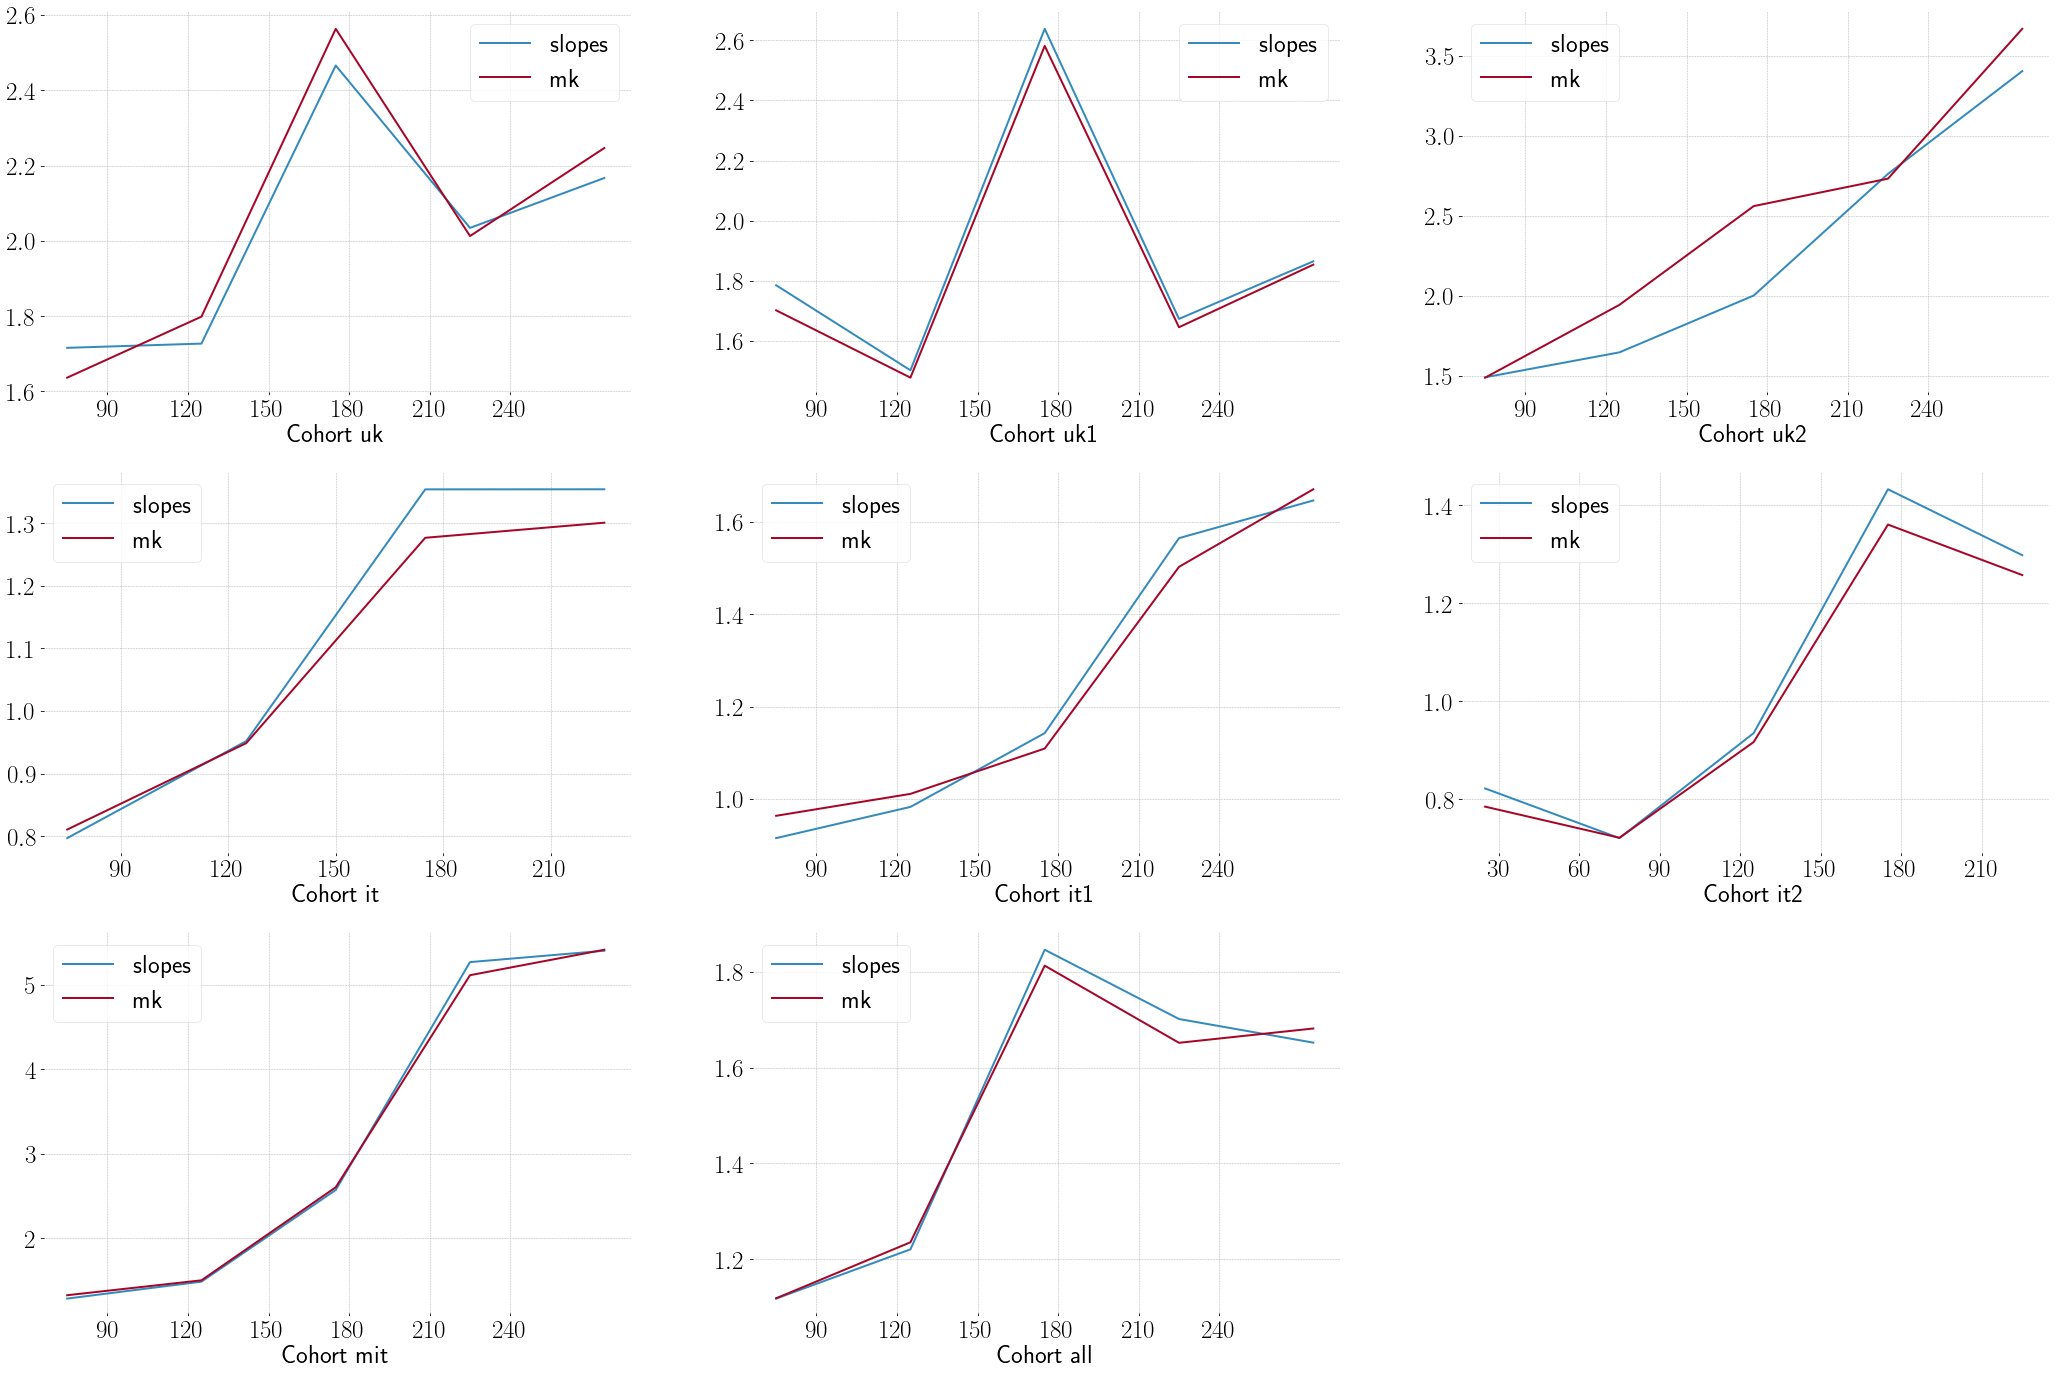

In [387]:
plt.figure(figsize=(12*3, 8*3))
p = 1
for c in bbins.keys():
    plt.subplot(3,3,p)
    df = bbins[c]
    #plt.semilogy()
    plt.xticks(range(0, 251, 30))
    plt.xlabel(f'Cohort {c}')
    plt.plot(df['x'], df['slopes'], label="slopes")
    plt.plot(df['x'], df['mk'], label='mk')
    plt.legend()
    p += 1

In [388]:
tmp = pd.DataFrame()
for c in bbins.keys():
    df = bbins[c].copy(deep=True)
    df.columns = [f's{c}', f'm{c}', f'x{c}']
    tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    
tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", index=False, header=True, sep="\t")

In [389]:
tmp

suk       muk    xuk      suk1      muk1   xuk1      suk2  \
lambda                                                                   
0            nan       nan    nan       nan       nan    nan       nan   
1       1.715829  1.636614   75.0  1.784566  1.701065   75.0  1.490812   
2       1.727107  1.798681  125.0  1.501273   1.47683  125.0  1.646674   
3       2.465909  2.563367  175.0  2.638596  2.581679  175.0  2.001913   
4       2.034465    2.0128  225.0  1.672477  1.644766  225.0  2.762282   
5       2.167062  2.246647  275.0  1.864236  1.853148  275.0  3.404696   

            muk2   xuk2       sit  ...   xit1      sit2      mit2   xit2  \
lambda                             ...                                     
0            nan    nan       nan  ...    nan  0.822169   0.78505   25.0   
1       1.488598   75.0  0.797083  ...   75.0  0.720851  0.721547   75.0   
2        1.94357  125.0  0.951975  ...  125.0  0.935192   0.91697  125.0   
3       2.560944  175.0  1.353889  ...  175.0   1.43262  1.360601  175.0   
4       2.732477  225.0  1.354017  ...  225.0  1.298147  1.257572  225.0   
5       3.669147  275.0       nan  ...  275.0       nan       nan    nan   

            smit      mmit   xmit      sall      mall   xall  
lambda                                                        
0            nan       nan    nan       nan       nan    nan  
1       1.288563  1.328228   75.0  1.117712  1.118345   75.0  
2       1.488594  1.504352  125.0  1.220513  1.235277  125.0  
3       2.572289  2.604059  175.0  1.846278  1.813026  175.0  
4       5.265624  5.110795  225.0  1.701613  1.651917  225.0  
5            5.4  5.411765  275.0  1.652258  1.681787  275.0  

[6 rows x 24 columns]

## Distribution of $b_i(\ell)$

In [390]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [391]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.6066666666666667, 0.01) (0.6066666666666667, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9970909090909091, 0.01) (0.9970909090909091, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(0.8936363636363638, 0.01) (0.8936363636363638, 1)};
=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.678517316017316, 0.01) (0.678517316017316, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.011904761904762, 0.01) (1.011904761904762, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.4743589743589747, 0.01) (1.4743589743589747, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.23114083983649206, 0.01) (0.23114083983649206, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.39673112338858196, 0.01) (0.3967311

In [392]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", index=False, header=True, sep="\t")

### Now using mann kendall

In [393]:
bhist2 = {}
for c in fig1.keys():
    bhist2[c] = {}
    for lamb in fig1[c].keys():
        bhist2[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve2 = fig1[c][lamb]['fi'][ego]
            if len(curve2) > 1:
                b = pc.get_b_mk(curve2)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist2[c][lamb].append(b[1][1])

In [394]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist2[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5b.dat", index=False, header=True, sep="\t")

=====================uk========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.6066666666666667, 0.01) (0.6066666666666667, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9970909090909091, 0.01) (0.9970909090909091, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.0984848484848486, 0.01) (1.0984848484848486, 1)};
=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.678517316017316, 0.01) (0.678517316017316, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9802721088435373, 0.01) (0.9802721088435373, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.4743589743589747, 0.01) (1.4743589743589747, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.23114083983649206, 0.01) (0.23114083983649206, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.39548802946593, 0.01) (0.39548802

## $p$-value distribution for the KS test

In [395]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

============	UK	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.79937106918239, 0.04) (0.79937106918239, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7826721763085399, 0.04) (0.7826721763085399, 1)};
============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8125850340136055, 0.04) (0.8125850340136055, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7448018648018647, 0.04) (0.7448018648018647, 1)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8717877094972067, 0.04) (0.8717877094972067, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.830894105894106, 0.04) (0.830894105894106, 1)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.9256756756756757, 0.04) (0.9256756756756757, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7489689797382104, 0.04) (0.7489689797382104, 1)};


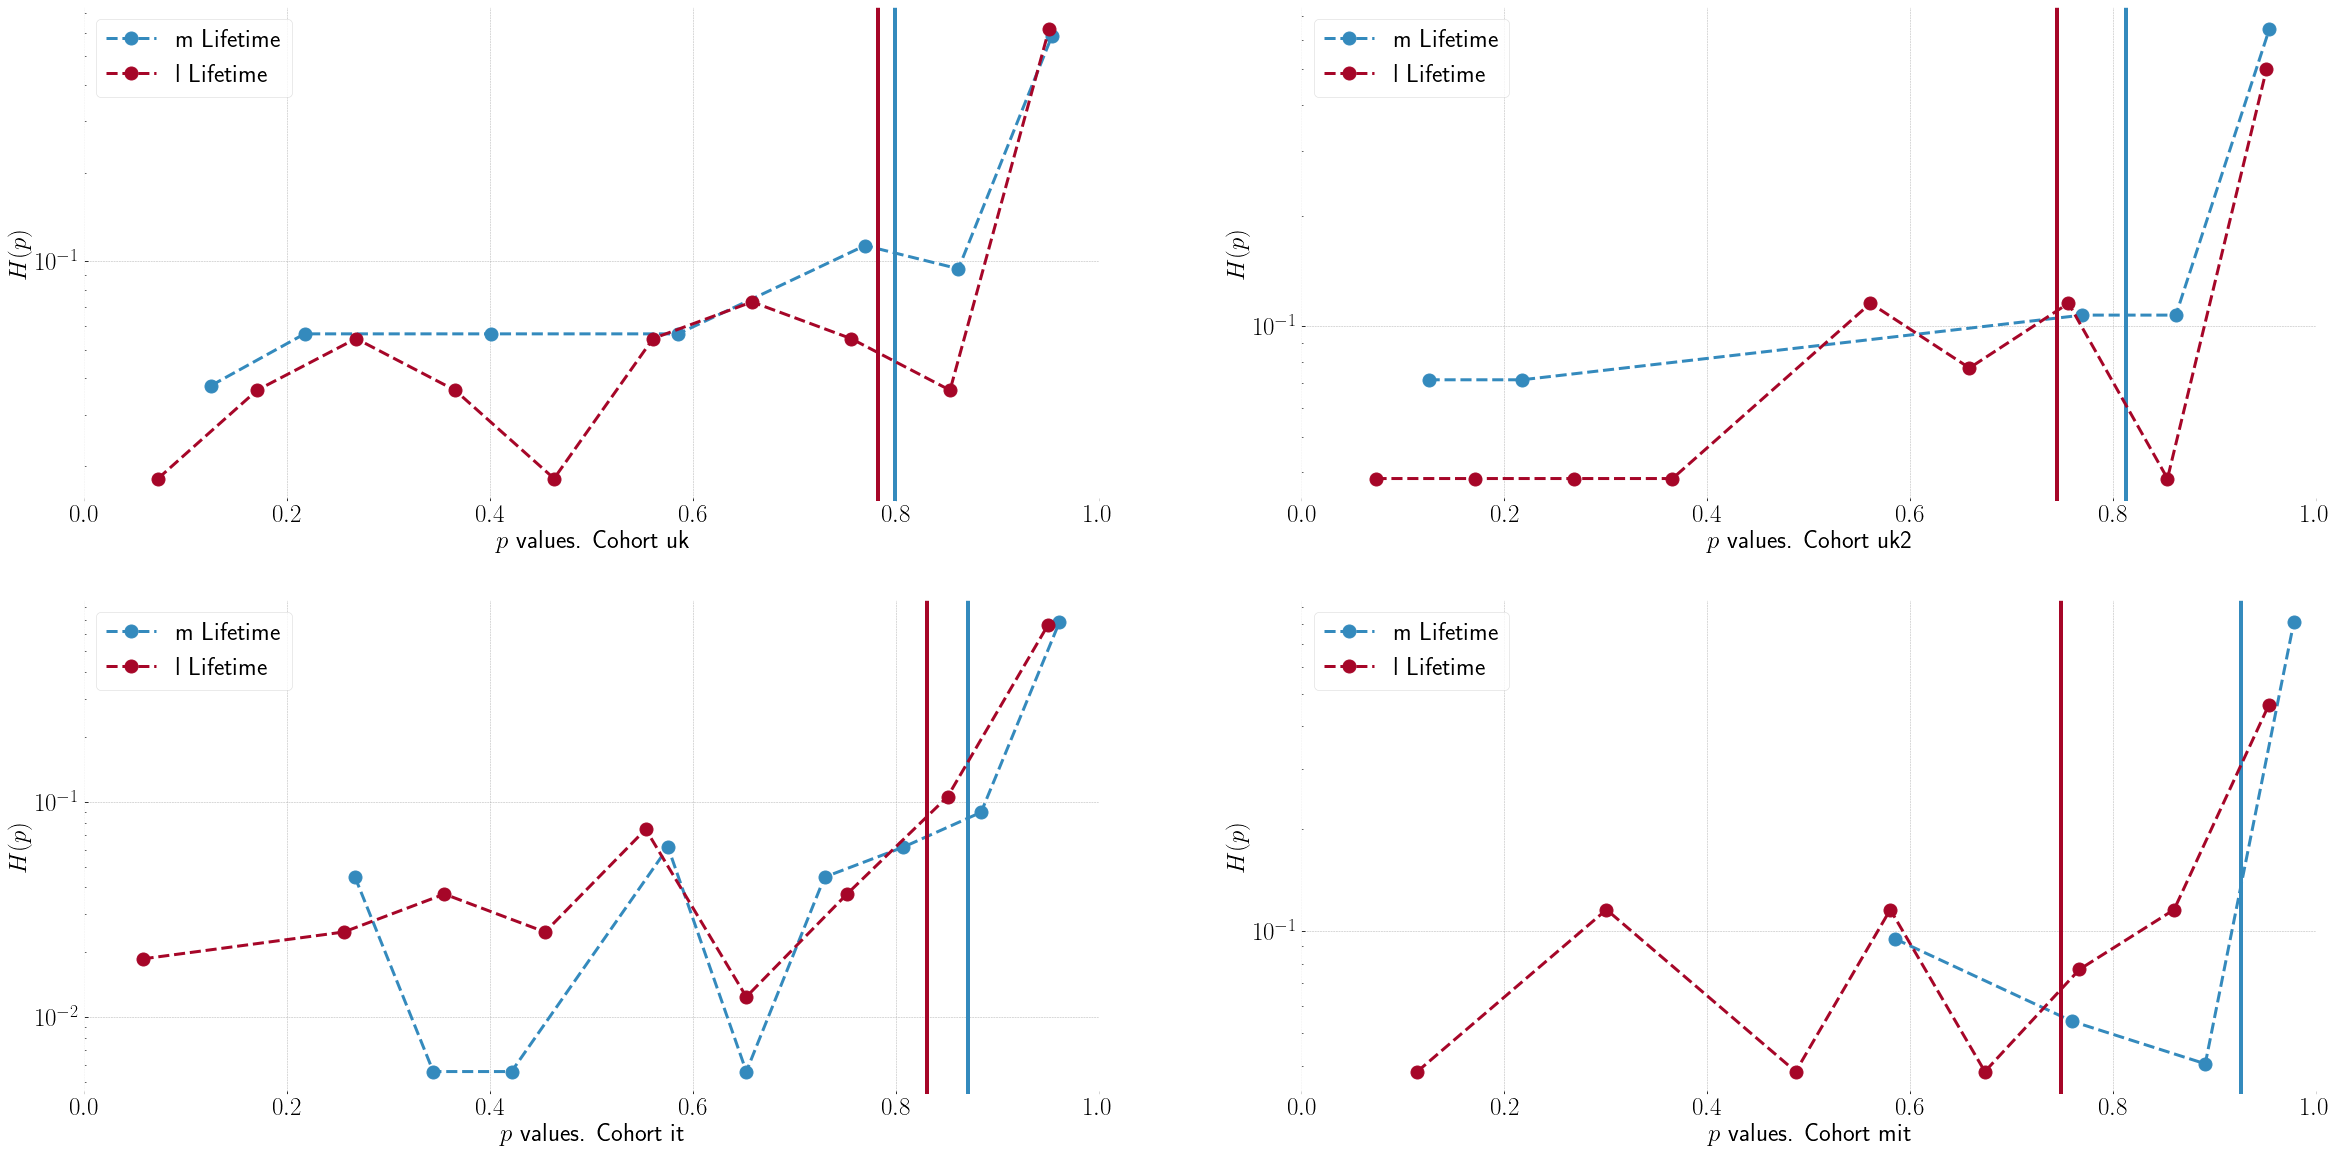

In [396]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(2, 2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.04) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1

In [397]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S6.dat", index=False, header=True, sep="\t")

## Identify $\ell_s$ for each cohort



In [400]:
def get_ells(bdf, col, lookforward=15):
    df = bdf[[col]].rolling(lookforward).mean()
    df2 = df.loc[df[col] == 1]
    if len(df2) > 0:
        return min(df2.index)
    else:
        return None  

In [401]:
egolist = {}
for c in dffcomb.keys():
    egolist[c] = [ego for ego in dffcomb[c].keys()]

In [402]:
t0 = dt.datetime.now()
bi = {}
bi2 = {}
convergei = {}
convergei2 = {}
niter = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    bi[c] = {}
    bi2[c] = {}
    convergei[c] = {}
    convergei2[c] = {}
    niter[c] = {}
    for ego in egolist[c]:
        bi[c][ego] = {}
        bi2[c][ego] = {}
        convergei[c][ego] = {}
        convergei2[c][ego] = {}
        niter[c][ego] = {}
        thisdf = {ego: dffcomb[c][ego]}
        for ell in range(271):
            curve = pc.get_avgfa(thisdf, lives[c], ell, ell + 50)
            if (curve is not None) and (len(curve) > 3):
                points = pc.get_b_slopes(curve, FlagConverge=True)
                points2 = pc.get_b_mk(curve, FlagConverge=True)
                bi[c][ego][ell] = points[1][1]
                bi2[c][ego][ell] = points2[1][1]
                convergei[c][ego][ell] = points[2]
                convergei2[c][ego][ell] = points2[2]
                niter[c][ego][ell] =  points2[3]
        if len(bi[c][ego].keys()) > 0:
            bi[c][ego] = pd.DataFrame.from_dict(bi[c][ego], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
            tmp = pd.DataFrame.from_dict(convergei[c][ego], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
            if ego in bi2[c].keys():
                tmpb2 = pd.DataFrame.from_dict(bi2[c][ego], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
                tmpc2 = pd.DataFrame.from_dict(convergei2[c][ego], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
            bi[c][ego] = bi[c][ego].merge(tmp, left_index=True, right_index=True, how='outer')
            if ego in bi2[c].keys():
                bi[c][ego] = bi[c][ego].merge(tmpb2, left_index=True, right_index=True, how='outer')
                bi[c][ego] = bi[c][ego].merge(tmpc2, left_index=True, right_index=True, how='outer')
                bi[c][ego]['mam'] = bi[c][ego]['mk'].rolling(window=50).mean()
            bi[c][ego]['mas'] = bi[c][ego]['slopes'].rolling(window=50).mean()
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:03:32.521621


In [62]:
type(bi['uk']['aC07974937643'])

pandas.core.frame.DataFrame

In [403]:
for ego in bi['mit'].keys():
    if type(bi['mit'][ego]) == pd.core.frame.DataFrame:
        print(np.mean(bi['mit'][ego]['convm']))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [404]:
bif = {}
bif['all'] = {}
for c in bi.keys():
    bif[c] = {}
    for ego in bi[c].keys():
        if type(bi[c][ego]) == pd.core.frame.DataFrame:
            bif[c][ego] = bi[c][ego]
            bif['all'].update(bif[c])

In [405]:
for c in ['uk', 'uk2', 'it', 'mit']:
    for ego in bif[c].keys():
        if ego not in bif['all'].keys():
            print('problem with', c, ego)
    else:
        print('success!', c)

success! uk
success! uk2
success! it
success! mit


In [406]:
ellsHs = {}
for c in bif.keys():
    ellsHs[c] = pc.histogram([get_ells(bif[c][ego], 'convs') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None], 10, log=False)

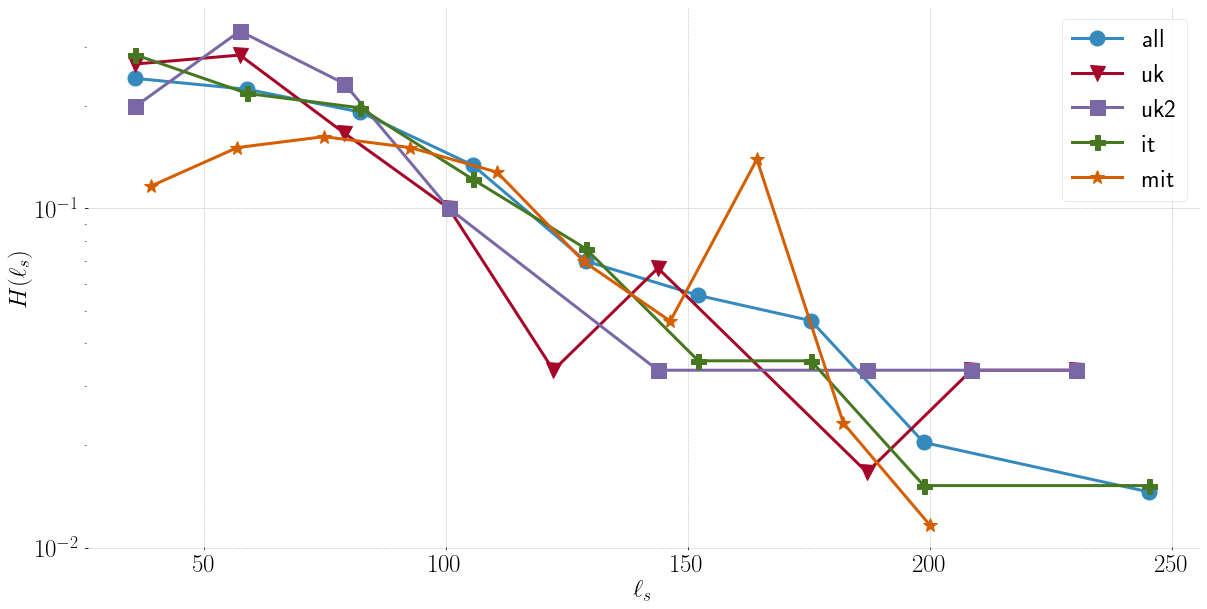

In [407]:
plt.semilogy()
plt.xlabel(r'$\ell_s$')
plt.ylabel(r'$H(\ell_s)$')
m = 0
for c in ellsHs.keys():
    plt.plot(ellsHs[c]['label'], ellsHs[c]['pmf'], marker=markers[m], ls="solid", markersize=15, lw=3, label=f'{c}')
    m += 1
plt.legend()

In [408]:
ellsHm = {}
for c in bif.keys():
    listells = [get_ells(bif[c][ego], 'convm') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convm') is not None]
    if len(listells) > 0:
        ellsHm[c] = pc.histogram(listells, 10, log=False)

In [409]:
tmp = pd.DataFrame()
for c in ellsHs.keys():
    print(f'================{c}=====================')
    H = ellsHs[c].copy(deep=True)
    H['tmp'] = H['label'] * H['h']
    avg = sum(H['tmp']) / sum(H['h'])
    print(avg)
    H = H[['label', 'pmf']]
    H = H.rename({'label': f'x{c}', 'pmf': f'y{c}'}, axis='columns')
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S9.dat", index=False, header=True, sep="\t")

================all=====================
85.1030612244898
================uk=====================
80.44
================uk2=====================
80.44
================it=====================
80.35761421319796
================mit=====================
98.68604651162788


In [410]:
tmp

xall      yall    xuk       yuk   xuk2      yuk2     xit       yit  \
0   35.65  0.241983   35.8  0.266667   35.8       0.2   35.65  0.284264   
1   58.95   0.22449   57.4  0.283333   57.4  0.333333   58.95  0.218274   
2   82.25   0.19242   79.0  0.166667   79.0  0.233333   82.25   0.19797   
3  105.55  0.134111  100.6       0.1  100.6       0.1  105.55  0.121827   
4  128.85  0.069971  122.2  0.033333    nan       nan  128.85  0.076142   
5  152.15  0.055394  143.8  0.066667  143.8  0.033333  152.15  0.035533   
6  175.45  0.046647    nan       nan    nan       nan  175.45  0.035533   
7  198.75  0.020408  187.0  0.016667  187.0  0.033333  198.75  0.015228   
8     nan       nan  208.6  0.033333  208.6  0.033333     nan       nan   
9  245.35  0.014577  230.2  0.033333  230.2  0.033333  245.35  0.015228   

     xmit      ymit  
0   38.95  0.116279  
1   56.85  0.151163  
2   74.75  0.162791  
3   92.65  0.151163  
4  110.55  0.127907  
5  128.45  0.069767  
6  146.35  0.046512  
7  164.25  0.139535  
8  182.15  0.023256  
9  200.05  0.011628

### Estimation from a regression

In [597]:
ellsHs['all']['logp'] = np.log(ellsHs['all']['pmf'])
ellsHs['all']

h       pmf   label      logp
0  83  0.241983   35.65 -1.418890
1  77  0.224490   58.95 -1.493925
2  66  0.192420   82.25 -1.648076
3  46  0.134111  105.55 -2.009089
4  24  0.069971  128.85 -2.659677
5  19  0.055394  152.15 -2.893291
6  16  0.046647  175.45 -3.065142
7   7  0.020408  198.75 -3.891820
9   5  0.014577  245.35 -4.228293

In [598]:
Y = np.array(ellsHs['all']['logp'])
X = np.array(ellsHs['all']['label'])
X = sm.add_constant(X)

In [599]:
model = sm.OLS(Y, X)
result = model.fit()
result.summary()

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     202.0
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           2.03e-06
Time:                        23:49:22   Log-Likelihood:                 2.7723
No. Observations:                   9   AIC:                            -1.545
Df Residuals:                       7   BIC:                            -1.150
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6418      0.153     -4.205      0.004      -1.003      -0.281
x1            -0.0148      0.001    -14.214      0.000      -0.017      -0.012
==============================================================================
Omnibus:                        0.977   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.735
Skew:                          -0.433   Prob(JB):                        0.692
Kurtosis:                       1.900   Cond. No.                         332.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [602]:
result.params

array([-0.64184507, -0.01482023])

In [603]:
np.exp(result.params[0])

0.5263204279014266

In [605]:
-1 / result.params[1]

67.47531481017711

## Fig 3 separated by country

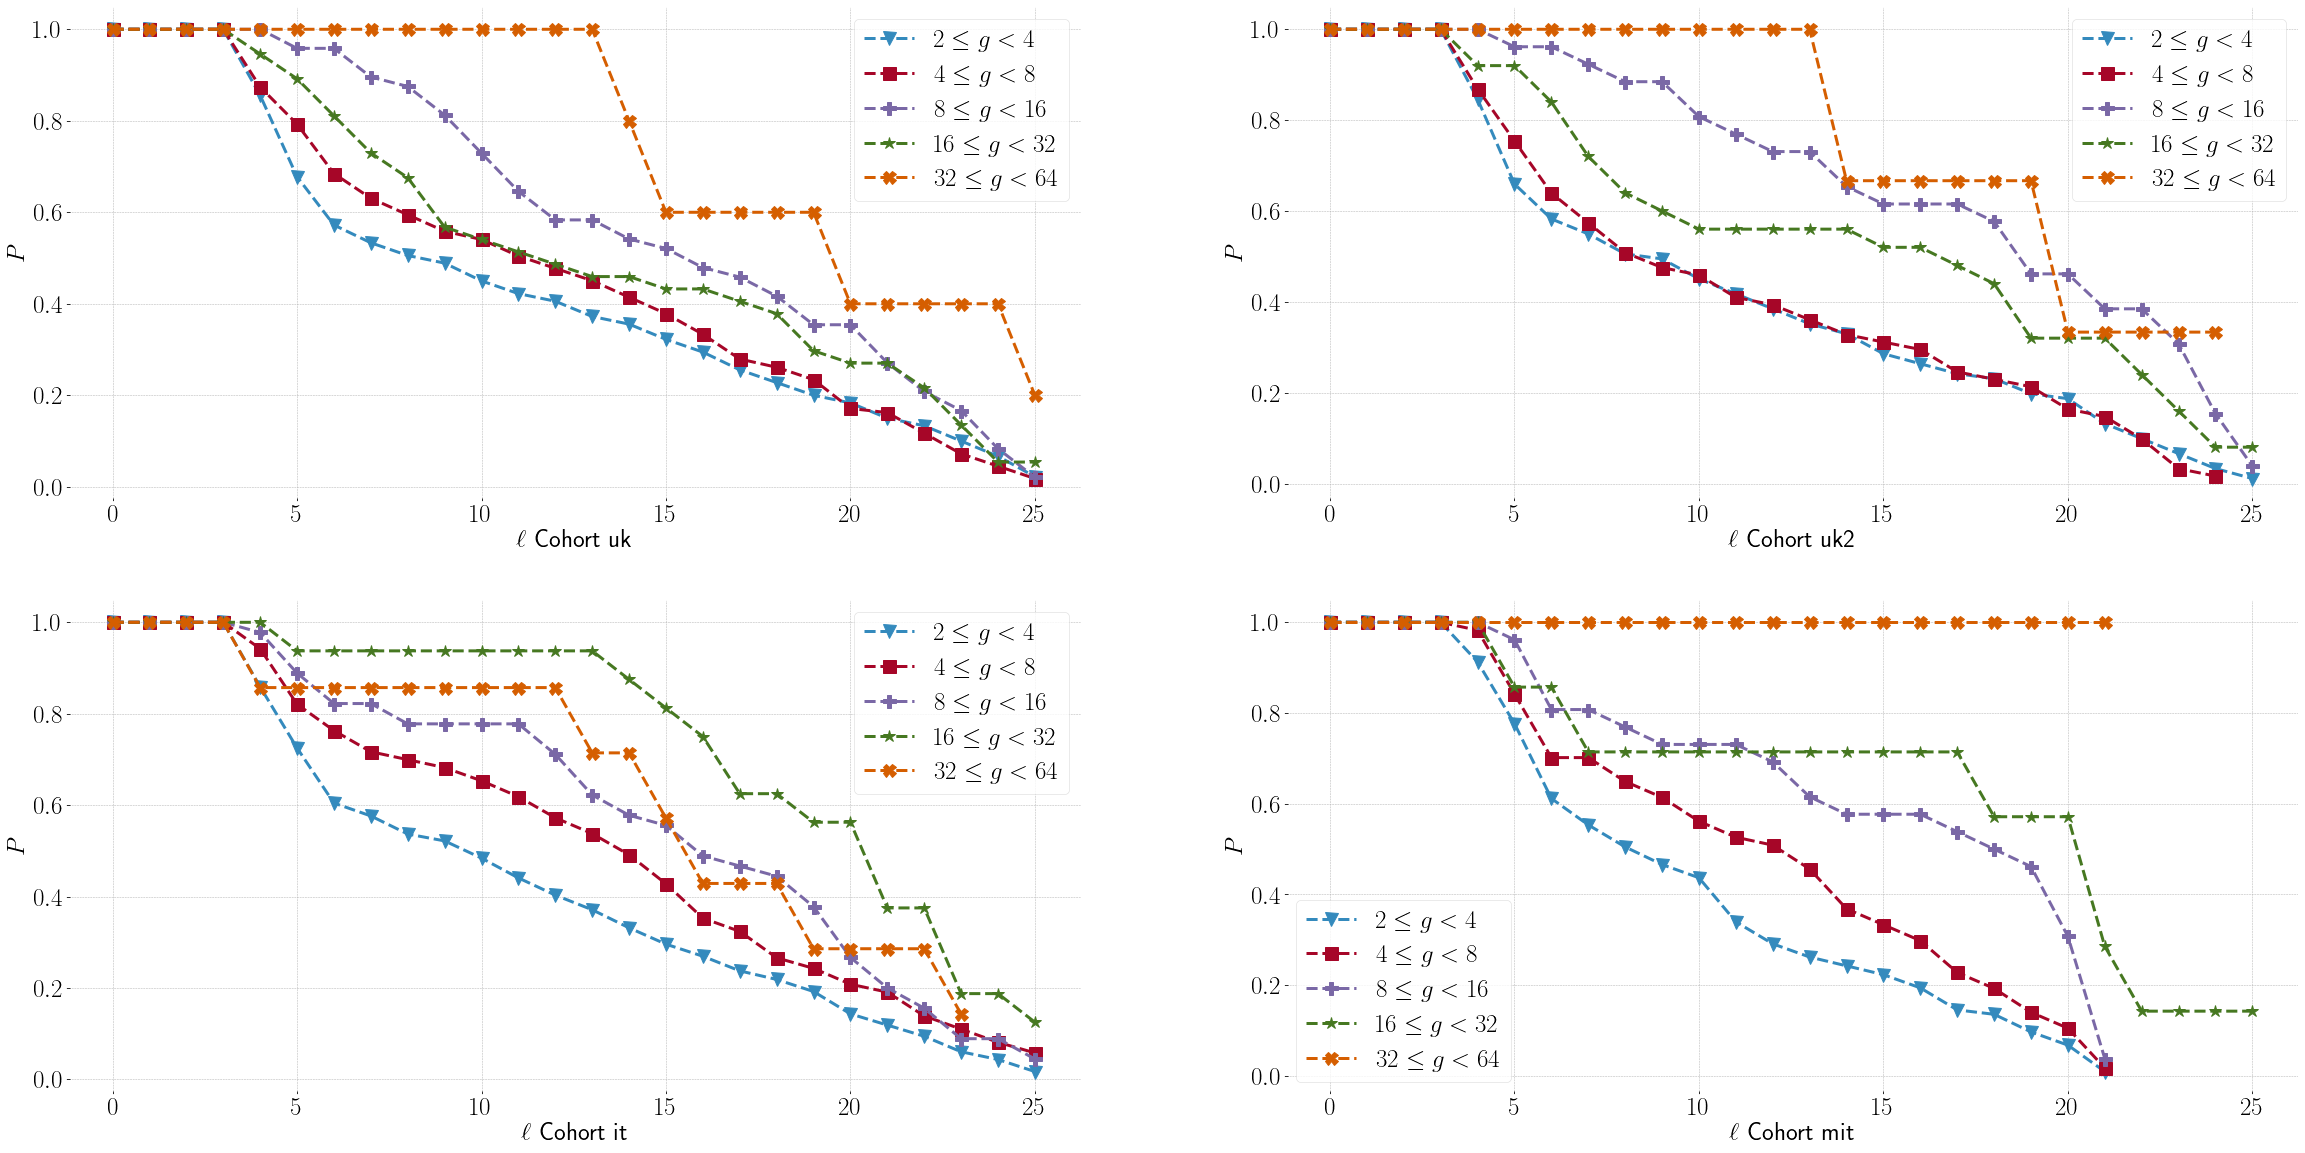

In [411]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(1,6):
        plt.plot(fig3[c][i].index, fig3[c][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()
    p += 1

In [439]:
tmp = pd.DataFrame()
for c in ['uk', 'uk2', 'mit', 'it']:
    for i in range(1, 6):
        tmp[f'{c}{i}'] = fig3[c][i]
        
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S7.dat", index=True, header=True, sep="\t")

### Alternative function

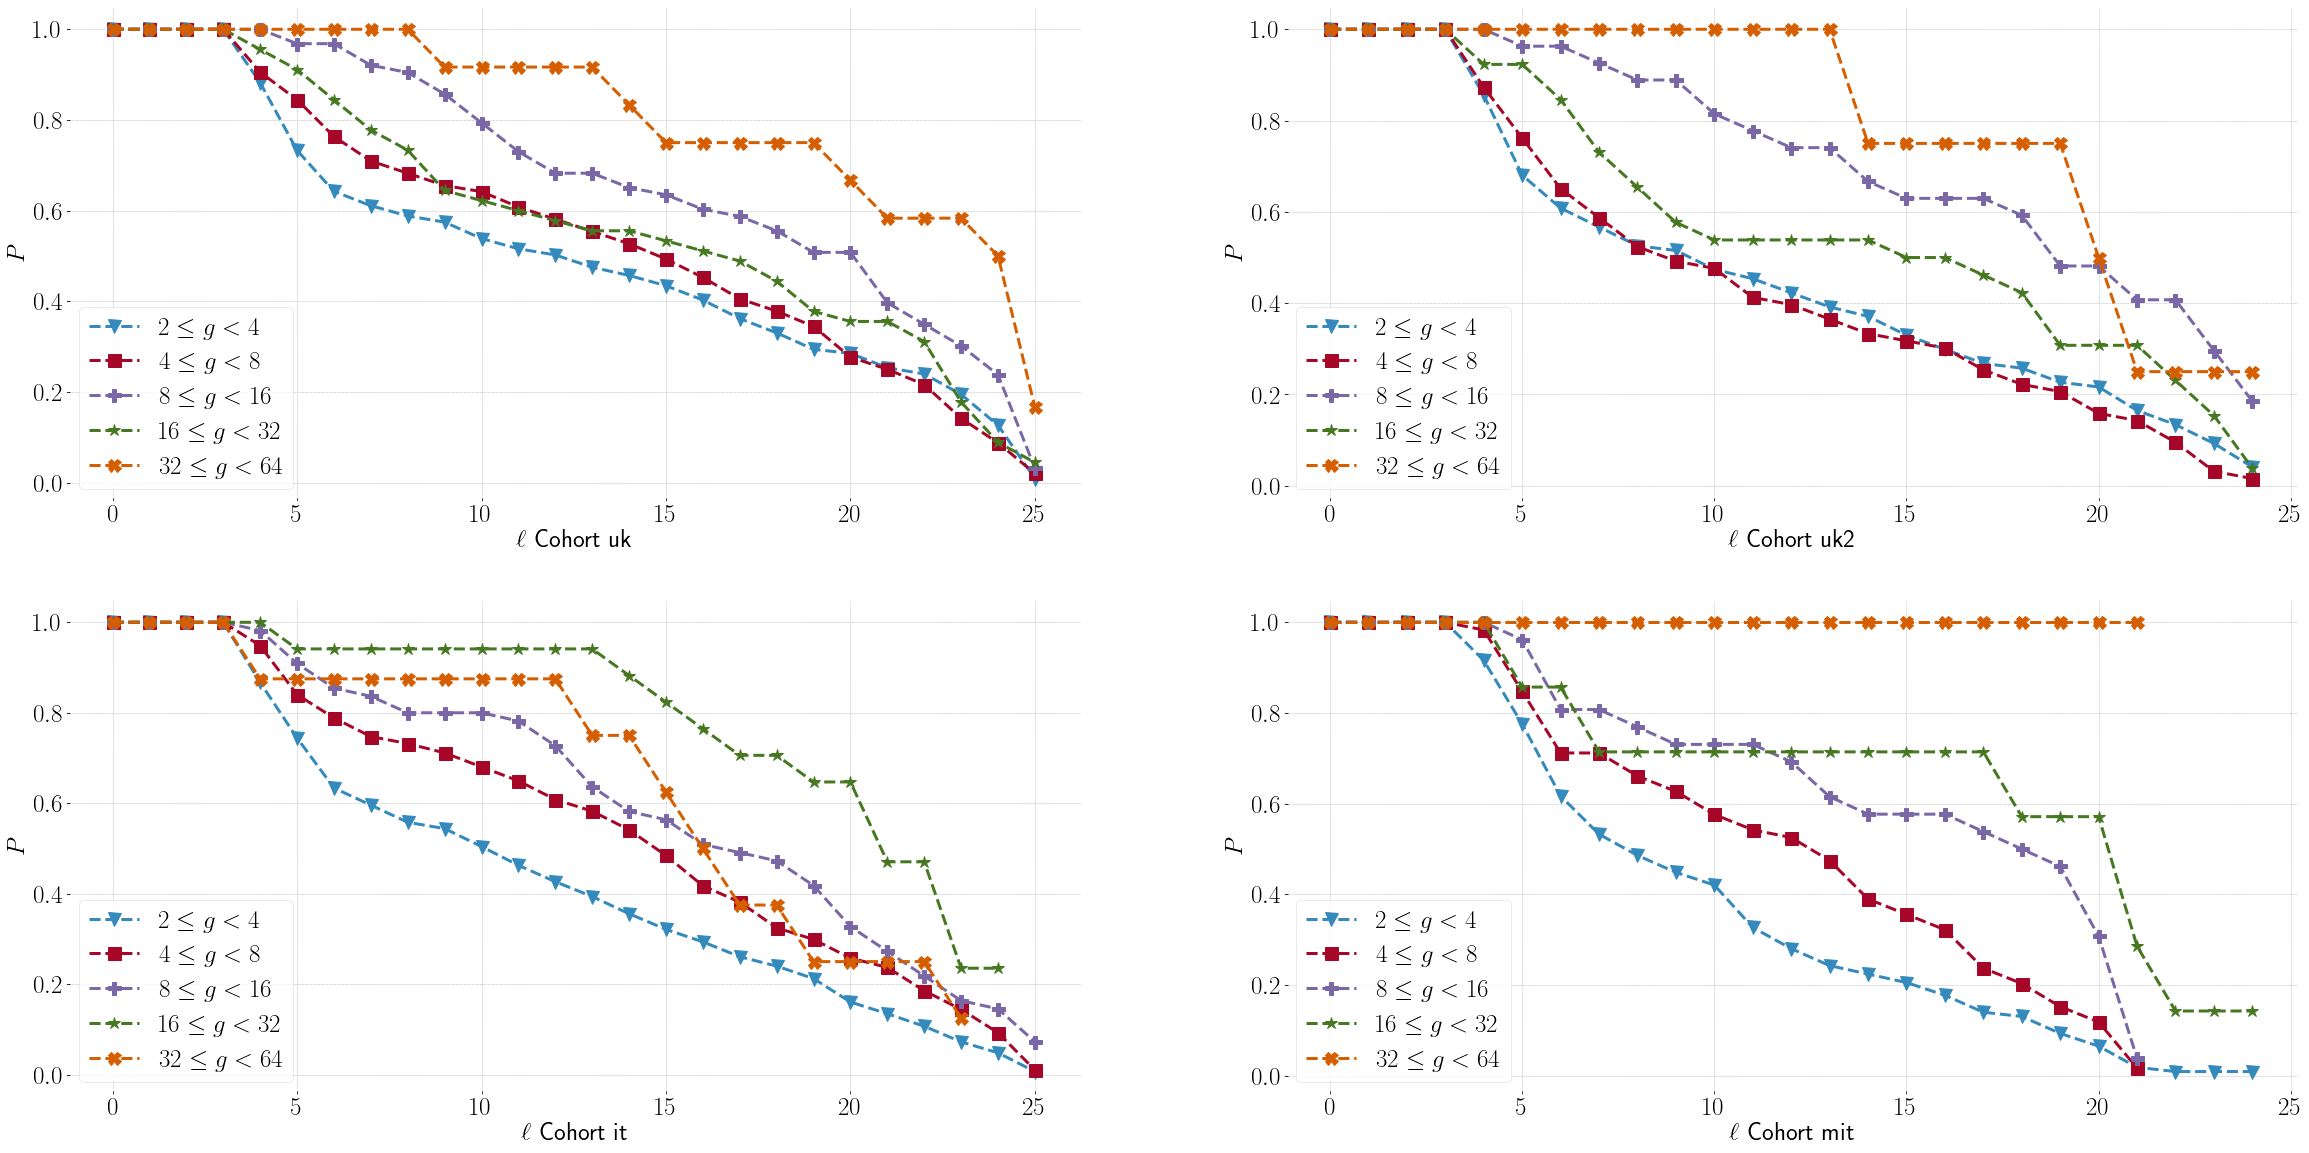

In [548]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(1,6):
        plt.plot(fig3b[c][i].index, fig3b[c][i]['p'], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()
    p += 1

## Change values of $a_o$ and $a_f$ for fig3

In [549]:
elements = [(0, 15), (30, 45), (60, 75), (0, 30), (30, 60), (60, 90), (0, 45), (30, 75), (60, 105), (0, 60), (30, 90), (60, 120)]

In [550]:
t0 = dt.datetime.now()
Ssva = {}
for p in range(len(elements)):
    Ssva[p + 1] = pc.get_survival2(callsurv['all'], elements[p][0], elements[p][1])
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.933515


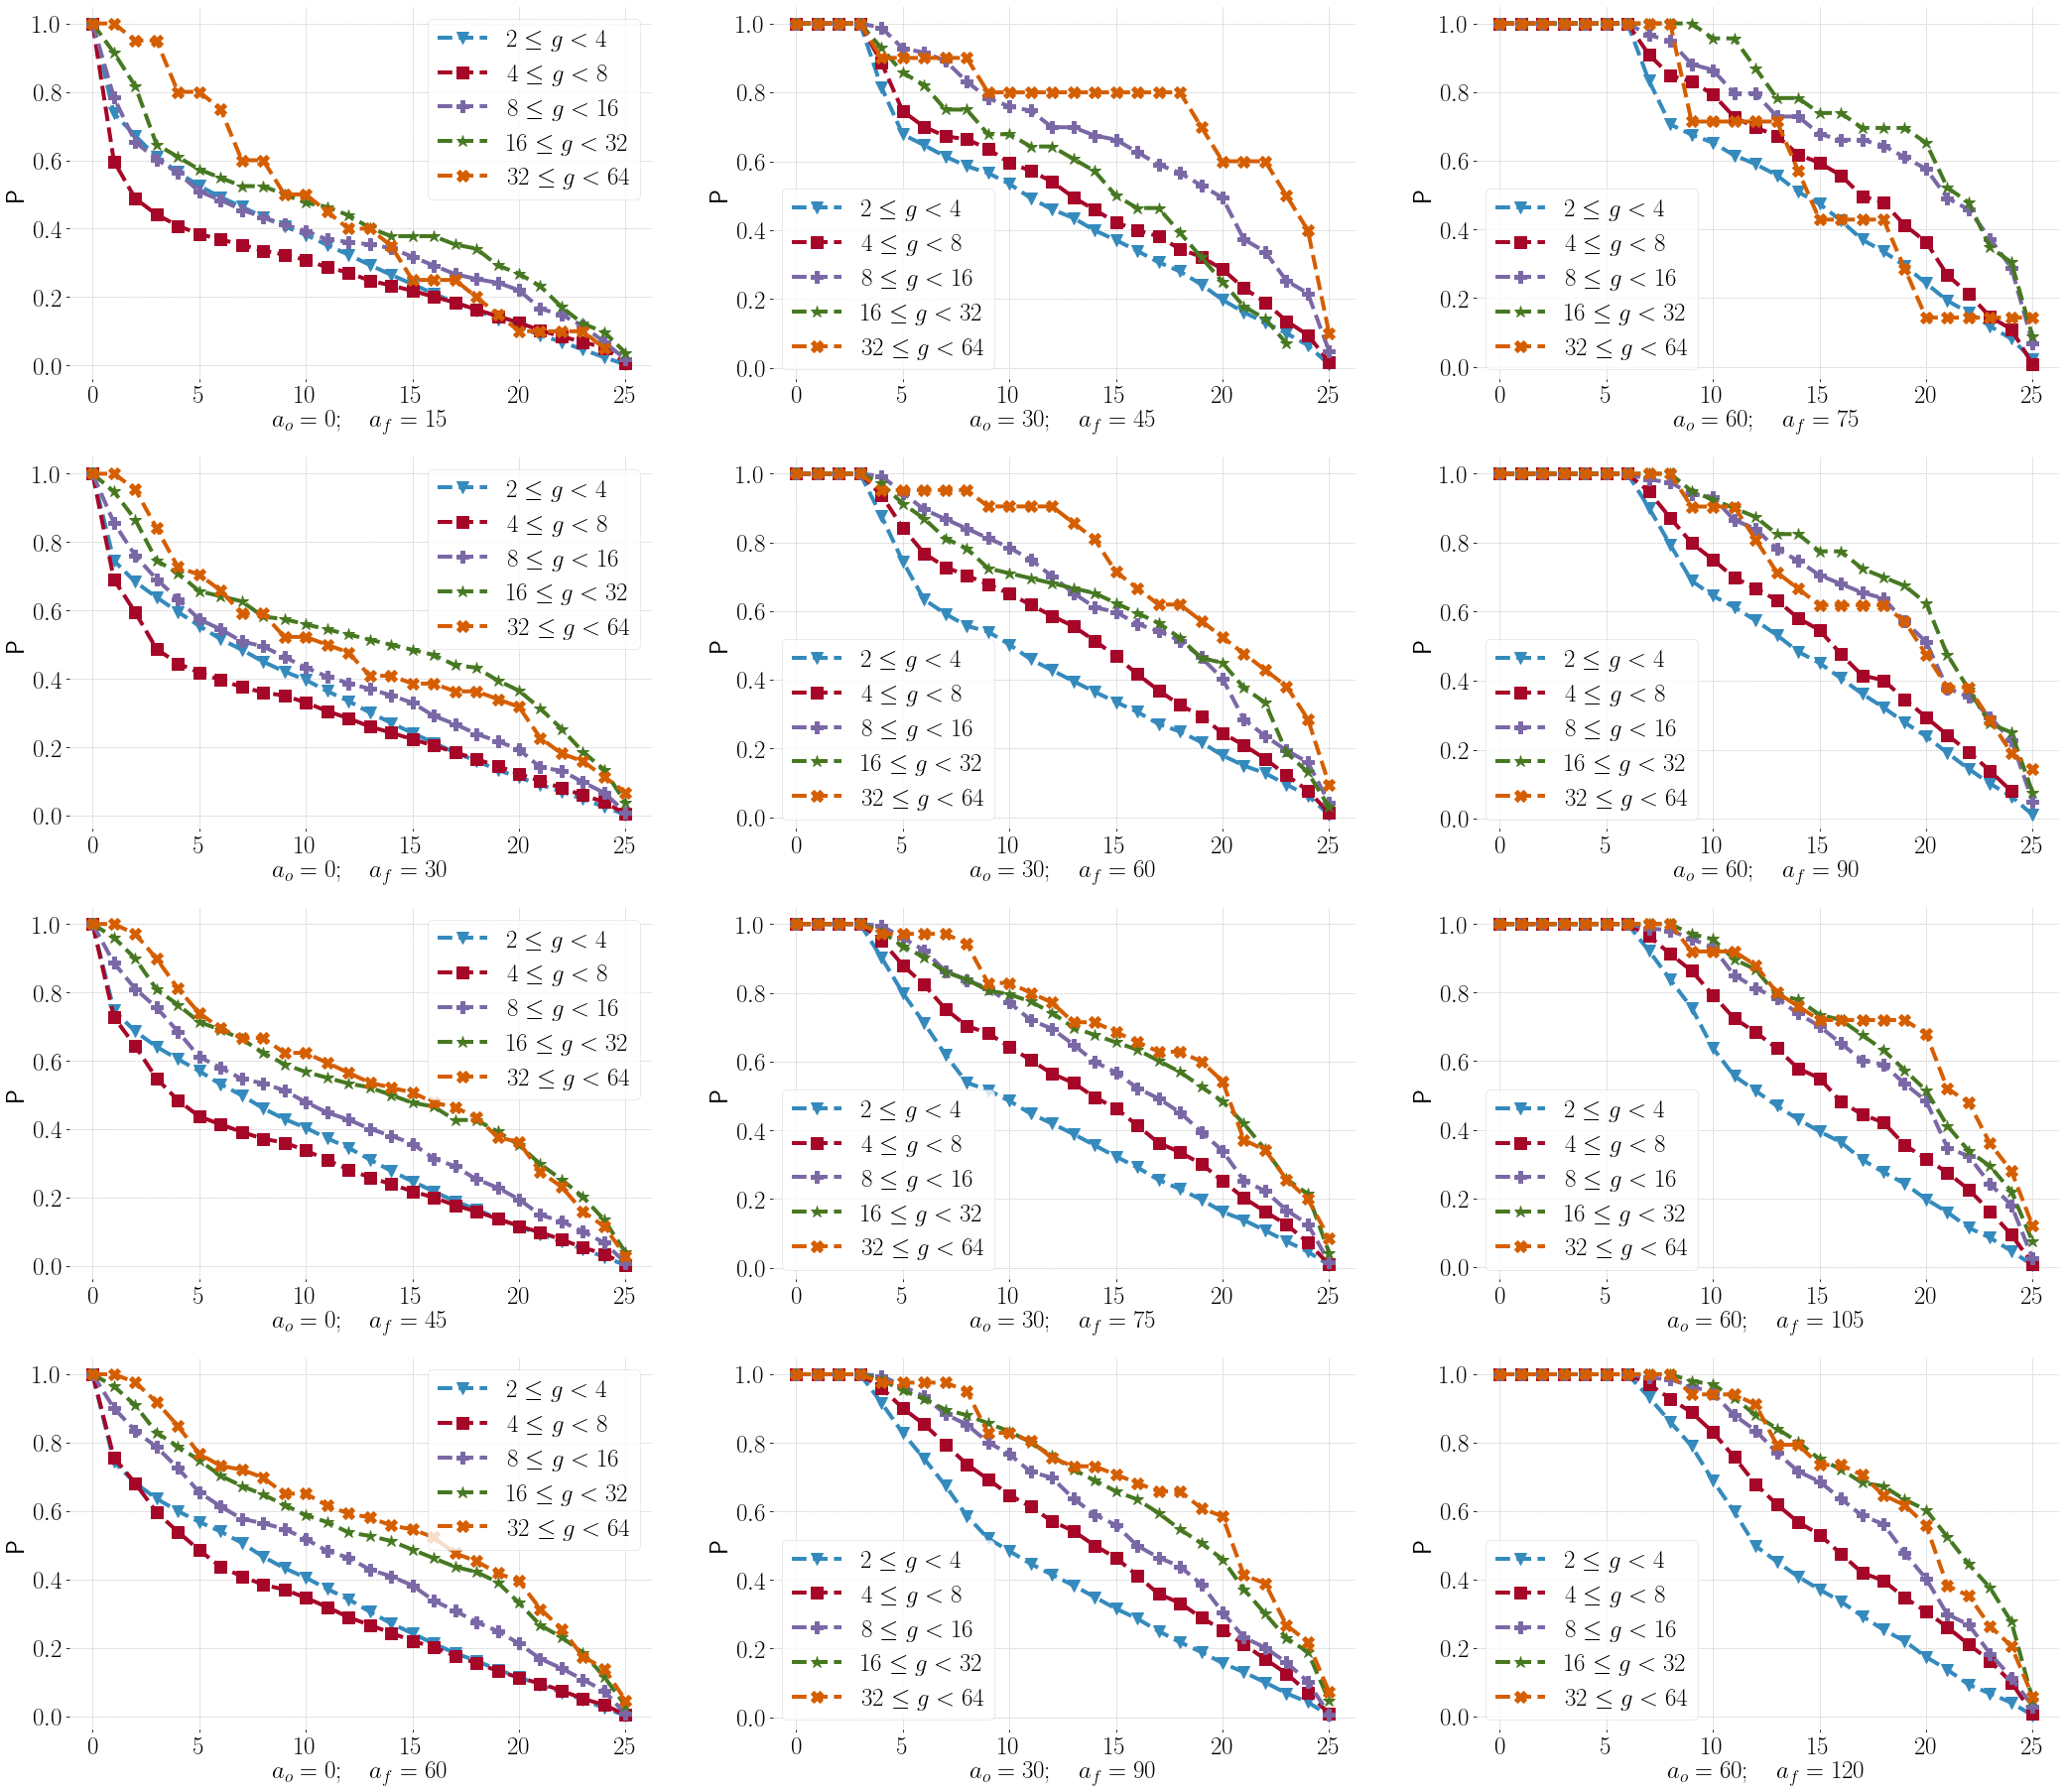

In [553]:
plt.figure(figsize=(12*3, 8*4))
for p in Ssva.keys():
    plt.subplot(4,3,p)
    plt.xlabel(fr'$a_o = {elements[p-1][0]}; \quad a_f = {elements[p-1][1]}$')
    plt.ylabel(r'P')
    for i in range(1, 6):
        plt.plot(Ssva[p][i].index, Ssva[p][i]['p'], marker=markers[i], ls="dashed", lw=4, markersize=12, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()

In [558]:
tmp = pd.DataFrame()
for p in Ssva.keys():
    for i in range(1, 6):
        df = Ssva[p][i].copy(deep=True)
        df.columns=[f'p{p}s{i}']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S8.dat", index=True, header=True, sep='\t')

In [559]:
tmp

p1s1      p1s2      p1s3      p1s4  p1s5      p2s1      p2s2  \
a                                                                       
0    1.000000  1.000000  1.000000  1.000000   1.0  1.000000  1.000000   
10   0.737348  0.597027  0.783394  0.914634   1.0  1.000000  1.000000   
20   0.672005  0.488263  0.653430  0.817073  0.95  1.000000  1.000000   
30   0.609225  0.441315  0.602888  0.646341  0.95  1.000000  1.000000   
40   0.565343  0.408451  0.563177  0.609756   0.8  0.815182  0.886364   
50   0.524984  0.384194  0.509025  0.573171   0.8  0.678218  0.745455   
60   0.492313  0.368545  0.483755  0.548780  0.75  0.646865  0.700000   
70   0.463805  0.352895  0.454874  0.524390   0.6  0.613861  0.672727   
80   0.434017  0.335681  0.433213  0.524390   0.6  0.585809  0.663636   
90   0.406470  0.323944  0.411552  0.500000   0.5  0.566007  0.636364   
100  0.382127  0.308294  0.393502  0.475610   0.5  0.534653  0.595455   
110  0.352338  0.287167  0.368231  0.463415  0.45  0.493399  0.572727   
120  0.323831  0.271518  0.361011  0.439024   0.4  0.460396  0.540909   
130  0.294042  0.248044  0.353791  0.402439   0.4  0.435644  0.495455   
140  0.265215  0.233959  0.342960  0.378049  0.35  0.399340  0.459091   
150  0.237668  0.218310  0.317690  0.378049  0.25  0.371287  0.422727   
160  0.209801  0.201095  0.292419  0.378049  0.25  0.339934  0.400000   
170  0.184497  0.183881  0.267148  0.353659  0.25  0.306931  0.381818   
180  0.161755  0.163537  0.252708  0.341463   0.2  0.280528  0.345455   
190  0.134529  0.143975  0.241877  0.292683  0.15  0.242574  0.322727   
200  0.112748  0.125196  0.220217  0.268293   0.1  0.198020  0.286364   
210  0.088405  0.102504  0.166065  0.231707   0.1  0.161716  0.231818   
220  0.068866  0.084507  0.148014  0.170732   0.1  0.132013  0.190909   
230  0.046445  0.068858  0.115523  0.121951   0.1  0.100660  0.136364   
240  0.023703  0.051643  0.068592  0.097561  0.05  0.066007  0.095455   
250  0.002562  0.007042  0.018051  0.036585   nan  0.009901  0.018182   

         p2s3      p2s4  p2s5  ...     p11s1     p11s2     p11s3     p11s4  \
a                              ...                                           
0    1.000000       1.0   1.0  ...  1.000000  1.000000  1.000000  1.000000   
10   1.000000       1.0   1.0  ...  1.000000  1.000000  1.000000  1.000000   
20   1.000000       1.0   1.0  ...  1.000000  1.000000  1.000000  1.000000   
30   1.000000       1.0   1.0  ...  1.000000  1.000000  1.000000  1.000000   
40   0.987952  0.928571   0.9  ...  0.917037  0.960754  0.995690  0.984127   
50   0.927711  0.857143   0.9  ...  0.828889  0.901099  0.965517  0.952381   
60   0.915663  0.821429   0.9  ...  0.754074  0.854003  0.935345  0.928571   
70   0.891566      0.75   0.9  ...  0.675556  0.795918  0.883621  0.896825   
80   0.831325      0.75   0.9  ...  0.587407  0.737834  0.853448  0.880952   
90   0.783133  0.678571   0.8  ...  0.521481  0.693878  0.801724  0.857143   
100  0.759036  0.678571   0.8  ...  0.484444  0.648352  0.767241  0.833333   
110  0.746988  0.642857   0.8  ...  0.447407  0.613815  0.715517  0.801587   
120  0.698795  0.642857   0.8  ...  0.415556  0.571429  0.698276  0.761905   
130  0.698795  0.607143   0.8  ...  0.384444  0.543171  0.637931  0.722222   
140  0.674699  0.571429   0.8  ...  0.350370  0.500785  0.590517  0.690476   
150  0.662651       0.5   0.8  ...  0.316296  0.464678  0.560345  0.658730   
160  0.626506  0.464286   0.8  ...  0.287407  0.412873  0.500000  0.634921   
170  0.590361  0.464286   0.8  ...  0.251111  0.359498  0.465517  0.595238   
180  0.566265  0.392857   0.8  ...  0.218519  0.332810  0.439655  0.547619   
190  0.530120  0.321429   0.7  ...  0.190370  0.290424  0.387931  0.507937   
200  0.493976      0.25   0.6  ...  0.157778  0.254317  0.306034  0.460317   
210  0.373494  0.178571   0.6  ...  0.131111  0.211931  0.232759  0.373016   
220  0.337349  0.142857   0.6  ...  0.101481  0.169545  0.202586  0.301587   
230  0.253012 

## Distribution of $g$

In [412]:
dffsurv.keys()

dict_keys(['all', 'it', 'uk', 'uk2', 'mit'])

In [413]:
gcount = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    gcount[c] = {}
    for ego in dffsurv[c].keys():
        for alter in dffsurv[c][ego].keys():
            tmp = dffsurv[c][ego][alter]
            tmp2 = tmp.loc[(tmp['alpha'] >= 2) & (tmp['alpha'] <= 3)]
            tmp3 = tmp.loc[tmp['alpha'] <= 20]
            if len(tmp2) > 0:
                ncalls = sum(tmp2['f'])
                gcount[c]['sample'] = gcount[c].get('sample', [])
                gcount[c]['sample'].append(ncalls)
            if len(tmp3) > 0:
                ncalls = sum(tmp3['f'])
                gcount[c]['all'] = gcount[c].get('all', [])
                gcount[c]['all'].append(ncalls)

In [414]:
ghist = {}
for c in gcount.keys():
    ghist[c] = {}
    for s in gcount[c].keys():
        ghist[c][s] = pc.histogram(gcount[c][s], 10, log=True)

In [415]:
ghist['uk2']['sample']

h       pmf       label
0.0  95  0.302548    1.000000
1.0  60  0.191083    1.689064
2.0  56  0.178344    2.852938
3.0  47  0.149682    4.818796
4.0  16  0.050955    8.139256
5.0  20  0.063694   13.747727
6.0  14  0.044586   23.220795
7.0   3  0.009554   39.221415
8.0   1  0.003185   66.247492
9.0   2  0.006369  111.896274

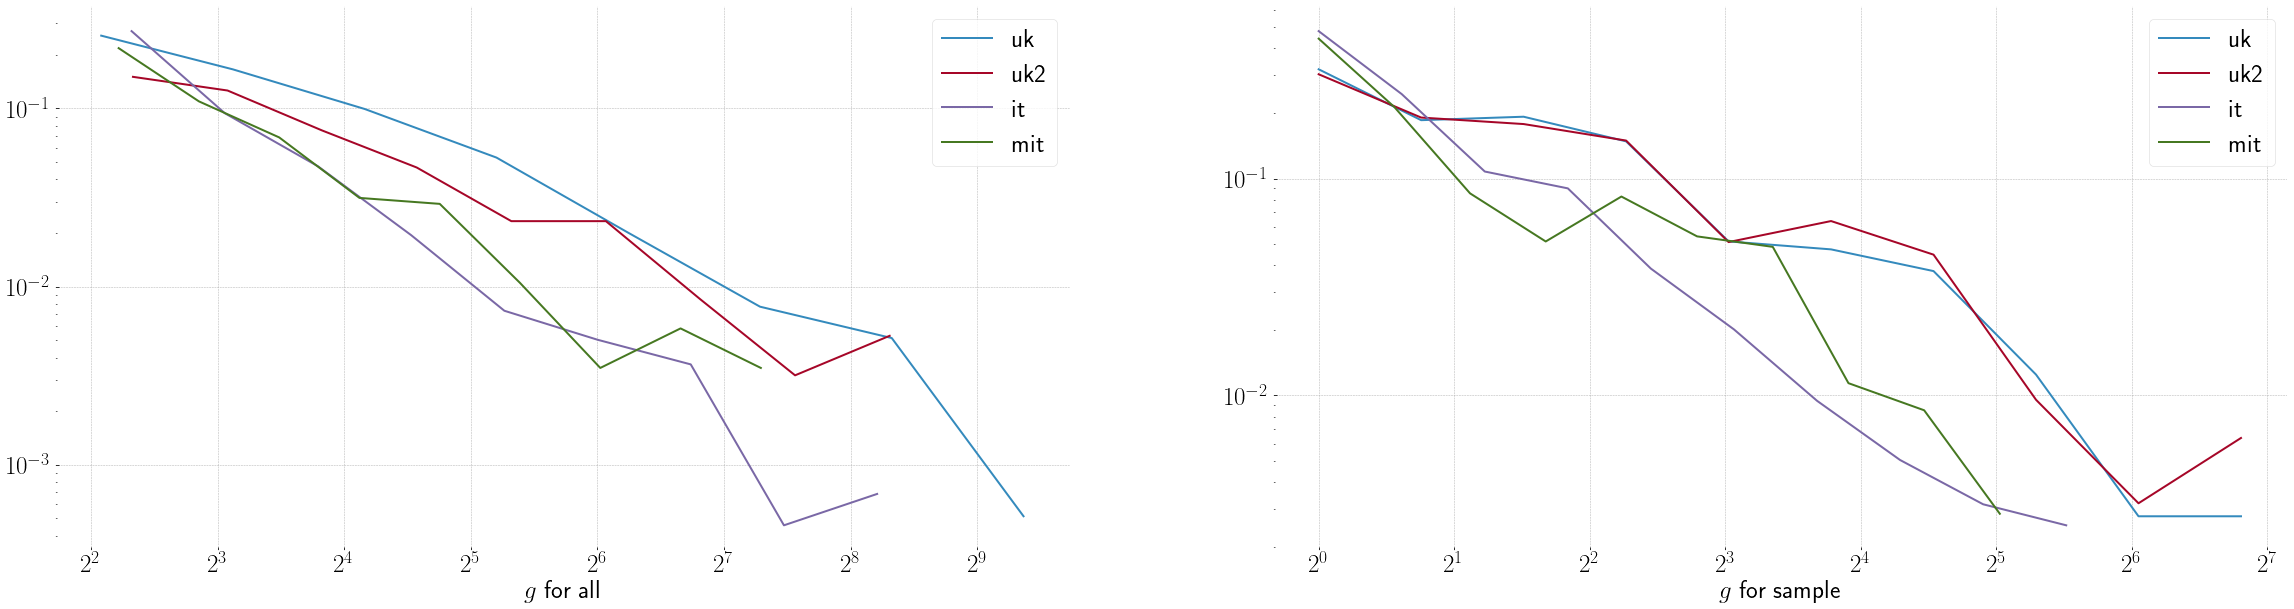

In [417]:
tmp = pd.DataFrame()
plt.figure(figsize=(20*2, 10*1))
p = 1
for s in ['all', 'sample']:
    plt.subplot(1,2,p)
    plt.xscale("log", base=2)
    plt.yscale("log")
    plt.xlabel(fr'$g$ for {s}')
    for c in ghist.keys():
        df = ghist[c][s]
        if s == 'all':
            df = df.loc[df['label'] > 3]
        df2 = df[['pmf', 'label']]
        df2.columns = [f'p{dict({"all": "a", "sample": "s"})[s]}{c}', f'x{dict({"all": "a", "sample": "s"})[s]}{c}']
        tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
        plt.plot(df['label'], df['pmf'], label=c)
    plt.legend()
    p += 1
tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S10.dat", index=False, header=True, sep="\t")

## Fig 2 using Mann Kendall Estimation

In [398]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist2.keys():
    for ell in [1, 2]:
        thelist = bhist2[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2downb.dat", index=False, header=True, sep="\t")

In [399]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bmdownb.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bldownb.dat", index=True, header=True, sep="\t")

## Variation on fig4

In [430]:
dffUI = {}
for c in ['uk', 'it']:
    dffUI.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffUI, alphafixed=(2,3), externalell=lives['all'], lambdamax=25)

In [431]:
surv_cont.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [432]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4ac.dat", header=False, index=False, sep="\t")

In [434]:
points_mit = pc.get_survival(dffsurv['mit'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_mit.keys():
    if s <= 2**5 + 1:
        df = points_mit[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4ap{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


In [435]:
dffMI = {}
for c in ['mit', 'it']:
    dffMI.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffMI, alphafixed=(2,3), externalell=lives['all'], lambdamax=25)

In [436]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4bc.dat", header=False, index=False, sep="\t")

In [437]:
points_uk = pc.get_survival(dffsurv['uk'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_uk.keys():
    if s <= 2**5 + 1:
        df = points_uk[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4bp{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# Proportion of phone calls used after filters

In [420]:
# t0 = dt.datetime.now()
# tmp = {}
# for c in ['uk', 'uk2', 'it', 'mit']:
#     tmp[c] = pc.lives_dictionary(unfiltered[c])
    
# counts = {}
# for c in ['uk', 'uk2', 'it', 'mit']:
#     alters = 0
#     ncalls = 0
#     a = 0
#     cc = 0
#     counts[c] = {}
#     for i in range(0, 301, 10):
#         tmpc = pc.apply_filters(unfiltered[c], i)
#         cdf = tmpc.loc[tmpc['aclock'] <= 300]
#         tmpl = pc.lives_dictionary(cdf)
#         tmpdff = pc.get_f(cdf, 'all', 15, 10)
#         for ego in tmp[c].keys():
#             for alter in tmp[c][ego].keys():
#                 vol = tmp[c][ego][alter]['nij']
#                 alters += 1
#                 ncalls += vol
#                 if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
#                     a += 1
#                     vol = tmpl[ego][alter]['nij']
#                     cc += vol
#             counts[c][i] = (a / alters, cc / ncalls)
#     counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))
    
# print(f'This block took {dt.datetime.now() - t0}')

This block took 0:02:15.516351


In [429]:
counts['it']

alters     calls
10   0.314058  0.482438
20   0.299203  0.422302
30   0.287372  0.385523
40   0.277477  0.359720
50   0.268621  0.339026
60   0.260726  0.322527
70   0.253432  0.308587
80   0.246806  0.296781
90   0.240635  0.286412
100  0.234776  0.277148
110  0.229232  0.268748
120  0.223920  0.261139
130  0.218784  0.253928
140  0.213883  0.247130
150  0.209251  0.240774
160  0.204866  0.234754
170  0.200644  0.228800
180  0.196551  0.223112
190  0.192534  0.217498
200  0.188600  0.212200
210  0.184702  0.207020
220  0.180883  0.202073
230  0.177156  0.197379
240  0.173556  0.192923
250  0.170102  0.188684
260  0.166782  0.184666
270  0.163555  0.180827
280  0.160436  0.177180
290  0.157412  0.173709
300  0.154501  0.170407

# Mutual Information

In [562]:
def get_month2(dff, lives):
    result = pd.DataFrame()
    idx = 0
    for ego in dff.keys():
        for alter in dff[ego].keys():
            df = dff[ego][alter].loc[(dff[ego][alter]['alpha'] >= 2) & (dff[ego][alter]['alpha'] <= 3)]
            if (len(df) > 0) and (ego in lives.keys()):
                result.at[idx, 'ego'] = ego
                result.at[idx, 'alter'] = alter
                result.at[idx, 'g'] = sum(df['f'])
                result.at[idx, 'lambda'] = lives[ego][alter]['ell']
                idx += 1
    return result

In [563]:
miall = []
for i in ['uk', 'uk2', 'it', 'mit', 'all']:
    miall.append(get_month2(dffsurv[i], lives['all']))

In [571]:
import sklearn.metrics as sk
miplot = []
for i in miall:
    miplot.append(sk.mutual_info_score(i['g'], i['lambda']))
for i in range(len(miplot)):
    print(['uk', 'uk2', 'it', 'mit', 'all'][i],"\t", miplot[i],"\t", miplot[i]*1.44)

uk 	 1.4372634047281319 	 2.06965930280851
uk2 	 1.8407683598093174 	 2.650706438125417
it 	 0.6022982275835145 	 0.8673094477202609
mit 	 1.2055186127818236 	 1.735946802405826
all 	 0.6133381719024639 	 0.883206967539548


In [572]:
entropies = []
for i in miall:
    X = stats.entropy([xx / sum(i["g"]) for xx in i['g']])
    Y = stats.entropy([yy / sum(i['lambda']) for yy in i['lambda']])
    entropies.append(np.mean([X, Y]))
    print(X, Y, np.mean([X, Y]))

5.706120045839427 6.380008909097102 6.043064477468264
4.767516836085946 5.545227261203276 5.156372048644611
6.85022028219716 7.184297375878365 7.017258829037763
5.329046987638391 5.703041506506391 5.516044247072391
7.134241727008224 7.693495569802573 7.413868648405398


In [573]:
for i in range(len(miplot)):
    print(['uk', 'uk2', 'mit', 'it', 'all'][i],"\t", miplot[i],"\t", miplot[i] / entropies[i])

uk 	 1.4372634047281319 	 0.23783684752777484
uk2 	 1.8407683598093174 	 0.3569890501390753
mit 	 0.6022982275835145 	 0.08583098361587786
it 	 1.2055186127818236 	 0.21854766908761578
all 	 0.6133381719024639 	 0.08272849182921294


# Testing area

In [155]:
general_count = 0
uk1_count = 0
for ego in dffcomb['uk'].keys():
    for alter in dffcomb['uk'][ego].keys():
        general_count += 1
        if ego[0] == 'a':
            uk1_count += 1
uk1_count / general_count

0.51440329218107

In [160]:
df = pd.read_csv("/Users/vsvh/Desktop/DataRelease/CallLog.csv")
df.head()

participantID.A participantID.B           local_time       type  duration  \
0      sp10-01-02             NaN  2010-08-04 19:11:51  outgoing+       NaN   
1      sp10-01-02             NaN  2010-08-04 18:49:26  outgoing+       NaN   
2      sp10-01-53      sp10-01-04  2010-07-10 19:24:25  outgoing+       NaN   
3      sp10-01-53      sp10-01-04  2010-07-10 19:24:17  outgoing+       NaN   
4      sp10-01-53             NaN  2010-07-15 18:04:23  incoming+       NaN   

                                number.hash  
0   da83375fb3a7631f304a9471add44eeb19d3355  
1   da83375fb3a7631f304a9471add44eeb19d3355  
2  e729a096a6c30c9f523e56329b4cdc7993d83b00  
3  e729a096a6c30c9f523e56329b4cdc7993d83b00  
4  ec5be5bbb1a719fc8c348ebbc577b99a61457575

In [161]:
df['type'].value_counts()

outgoing     81853
incoming     41763
missed       19854
outgoing+    12600
incoming+     8834
Name: type, dtype: int64

In [219]:
%time df2 = pc.allcalls('/Users/vsvh/Desktop/DataRelease/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=3)
df2.head()

CPU times: user 177 ms, sys: 12.4 ms, total: 189 ms
Wall time: 189 ms


ego                                     alter                time  \
0  fa10-01-02  1043c890655a5cb161a66c54e10929cebe3f9258 2011-05-12 10:16:13   
1  fa10-01-02  1043c890655a5cb161a66c54e10929cebe3f9258 2011-05-19 10:21:01   
2  fa10-01-02  1043c890655a5cb161a66c54e10929cebe3f9258 2011-06-09 10:30:25   
3  fa10-01-02  1043c890655a5cb161a66c54e10929cebe3f9258 2011-06-17 13:02:24   
4  fa10-01-02  1043c890655a5cb161a66c54e10929cebe3f9258 2011-07-04 11:42:21   

   uclock  aclock  
0     438       0  
1     445       7  
2     466      28  
3     474      36  
4     491      53

In [577]:
print(min(unfiltered['it2']['time']))
print(max(unfiltered['it2']['time']))

2014-01-01 00:05:17
2014-12-30 23:40:54
